In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
import pickle as pickle
# 이거 데이터프레임 숫자 표시 개수 정해주는 거
pd.options.display.float_format = '{:.4f}'.format
import warnings
warnings.filterwarnings('ignore')
import matplotlib.gridspec as gridspec

In [10]:
# train, dev, test 파일 load
train = pd.read_csv('/opt/ml/dataset/train/train.csv')
dev = pd.read_csv('/opt/ml/code/prediction/0_dev_loss_st.csv')
test = pd.read_csv('/opt/ml/code/prediction/0_test_st.csv')

In [11]:
# label 파일 load
num_label = []
label = dev['gold_label'].unique()
with open('/opt/ml/code/dict_label_to_num.pkl', 'rb') as f:
    dict_label_to_num = pickle.load(f)
    for v in label:
        num_label.append(dict_label_to_num[v])

In [12]:
def pred_pd(dev_dataset,label_dict):
    # 데이터 프레임
    temp = dev_dataset['probs'].apply(lambda x: pd.Series(np.array(eval(x))))
    temp.columns=label_dict
    concatSet = pd.concat([dev_dataset[['id','gold_label','pred_label']],temp],axis=1)
    second_label=[]
    second_prob=[]
    pred_prob=[]
    gold_prob=[]
    prob_diff=[]
    prse_diff=[]
    for i,r in concatSet.iterrows():
        prob_sort = r[3:].sort_values()
        second_label.append(prob_sort.keys()[-2])
        second_prob.append(prob_sort[-2])
        pred_prob.append(r[concatSet['pred_label'][i]])
        gold_prob.append(r[concatSet['gold_label'][i]])
        prob_diff.append(r[concatSet['pred_label'][i]]-r[concatSet['gold_label'][i]])    
        prse_diff.append(r[concatSet['pred_label'][i]]-prob_sort[-2])
    concatSet['second_label'] = second_label
    concatSet['second_prob'] = second_prob
    concatSet['pred_prob'] = pred_prob
    concatSet['gold_prob'] = gold_prob
    concatSet['prob_diff'] = prob_diff
    concatSet['prse_diff'] = prse_diff
    del temp,  pred_prob, gold_prob, prob_diff, prob_sort, second_label, second_prob, prse_diff
    return concatSet

In [13]:
full_dev = pred_pd(dev,dict_label_to_num)

In [14]:
def train_pred(train,pred):
    subjt=train['subject_entity'].apply(lambda x: pd.Series(eval(x))).add_prefix('subj_')
    objt=train['object_entity'].apply(lambda x: pd.Series(eval(x))).add_prefix('obj_')
    full_train = pd.concat([train[['id','sentence','source']],subjt,objt],axis=1)
    out_pd = pd.merge(full_train,pred,on='id',how='right')
    del subjt,objt,full_train
    return out_pd

In [16]:
tp = train_pred(train,full_dev)
tp.head(5)

,id,sentence,source,subj_word,subj_start_idx,subj_end_idx,subj_type,obj_word,obj_start_idx,obj_end_idx,...,per:place_of_birth,per:place_of_death,org:founded_by,per:religion,second_label,second_prob,pred_prob,gold_prob,prob_diff,prse_diff
0,9127,이 돈가스집은 백종원 더본코리아 대표가 지난해 11월 ‘골목식당‘ 서울 홍은동 포방...,wikitree,더본코리아,12,16,ORG,백종원,8,10,...,0.0000,0.0000,0.0000,0.0000,per:title,0.0000,0.9999,0.9999,0.0000,0.9998
1,18956,경기 양평군(군수 정동균)은 지난 18일 별관4층 대회의실에서 2030년까지 양평의...,wikitree,양평군,3,5,ORG,정동균,10,12,...,0.0000,0.0000,0.0000,0.0000,org:founded_by,0.0000,0.9999,0.9999,0.0000,0.9999
2,13521,올시즌 프로에 데뷔한 센터백 최규백이 2016년 하계 올림픽 국가대표팀으로 발탁되었다.,wikipedia,최규백,16,18,PER,센터백,12,14,...,0.0000,0.0000,0.0000,0.0000,per:parents,0.0000,0.9997,0.9997,0.0000,0.9997
3,31250,NTSB는 1967년 4월 1일 대통령 직속기관으로 설립되었다.,wikipedia,NTSB,0,3,ORG,1967년 4월 1일,6,16,...,0.0000,0.0000,0.0001,0.0000,org:dissolved,0.0002,0.9990,0.9990,0.0000,0.9988
4,14236,리그 우승으로 2007 AFC 챔피언스리그 티켓을 획득한 성남은 조별 예선과 8강전...,wikipedia,우라와 레드 다이아몬즈,69,80,ORG,2007,8,11,...,0.0000,0.0000,0.0000,0.0000,org:member_of,0.0000,0.9999,0.9999,0.0000,0.9999


In [18]:
# match : gold_label == pred_label / no_match : gold_label != pred_label
match=tp[tp['gold_label']==tp['pred_label']][['sentence','subj_word','subj_type','obj_word','obj_type','gold_label','pred_label','second_label','gold_prob','pred_prob','second_prob','prob_diff','prse_diff']]
no_match=tp[tp['gold_label']!=tp['pred_label']][['sentence','subj_word','subj_type','obj_word','obj_type','gold_label','pred_label','second_label','gold_prob','pred_prob','second_prob','prob_diff','prse_diff']]
second_match = tp[tp['gold_label']==tp['second_label']][['sentence','subj_word','subj_type','obj_word','obj_type','gold_label','pred_label','second_label','gold_prob','pred_prob','second_prob','prob_diff','prse_diff']]

In [21]:
all_count=[]
match_count=[]
nomatch_count=[]
second_fp= []
second_sp= []
for i in range(0,10):
    all_count.append(len(tp[(tp['pred_prob']>i*0.1)&(tp['pred_prob']<=(i+1)*0.1)]))
    match_count.append(len(match[(match['pred_prob']>i*0.1)&(match['pred_prob']<=(i+1)*0.1)]))
    nomatch_count.append(len(no_match[(no_match['pred_prob']>i*0.1)&(no_match['pred_prob']<=(i+1)*0.1)]))    
    second_fp.append(len(second_match[(second_match['pred_prob']>i*0.1)&(second_match['pred_prob']<=(i+1)*0.1)])) 
    second_sp.append(len(second_match[(second_match['second_prob']>i*0.1)&(second_match['second_prob']<=(i+1)*0.1)])) 

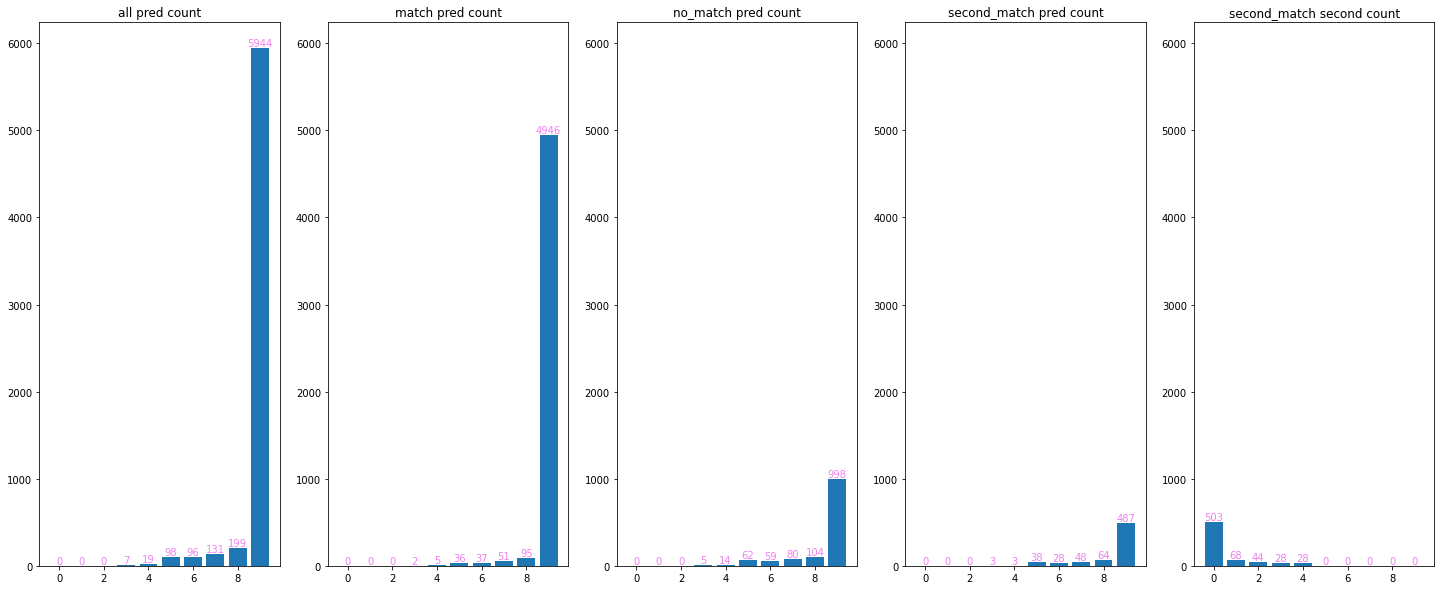

In [28]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(151)
ax2 = fig.add_subplot(152, sharey=ax1)
ax3 = fig.add_subplot(153, sharey=ax1)
ax4 = fig.add_subplot(154, sharey=ax1)
ax5 = fig.add_subplot(155, sharey=ax1)

ax1.bar(range(0,10),all_count)
ax2.bar(range(0,10),match_count)
ax3.bar(range(0,10),nomatch_count)
ax4.bar(range(0,10),second_fp)
ax5.bar(range(0,10),second_sp)
for i, v in enumerate(range(0,10)):
    ax1.text(v, all_count[i], all_count[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    ax2.text(v, match_count[i], match_count[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    ax3.text(v, nomatch_count[i], nomatch_count[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    ax4.text(v, second_fp[i], second_fp[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    ax5.text(v, second_sp[i], second_sp[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
ax1.set_title('all pred count')
ax2.set_title('match pred count')
ax3.set_title('no_match pred count')
ax4.set_title('second_match pred count')
ax5.set_title('second_match second count')
plt.show()

In [24]:
all_per =list(map(lambda x: round(x/sum(all_count),2),all_count))
match_per = list(map(lambda x: round(x/sum(match_count),2),match_count))
nomatch_per = list(map(lambda x: round(x/sum(nomatch_count),2),nomatch_count))
second_fp_per = list(map(lambda x: round(x/sum(second_fp),2),second_fp))
second_sp_per = list(map(lambda x: round(x/sum(second_sp),2),second_sp))

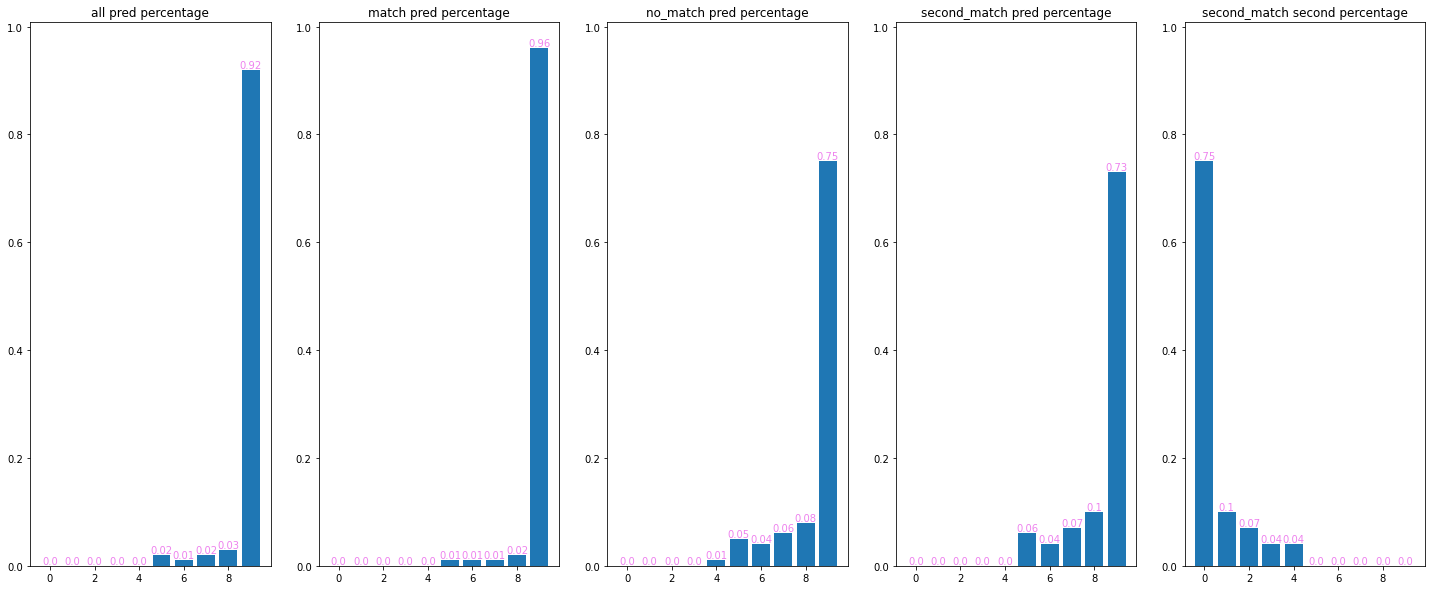

In [27]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(151)
ax2 = fig.add_subplot(152, sharey=ax1)
ax3 = fig.add_subplot(153, sharey=ax1)
ax4 = fig.add_subplot(154, sharey=ax1)
ax5 = fig.add_subplot(155, sharey=ax1)

ax1.bar(range(0,10),all_per)
ax2.bar(range(0,10),match_per)
ax3.bar(range(0,10),nomatch_per)
ax4.bar(range(0,10),second_fp_per)
ax5.bar(range(0,10),second_sp_per)
for i, v in enumerate(range(0,10)):
    ax1.text(v, all_per[i], all_per[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    ax2.text(v, match_per[i], match_per[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    ax3.text(v, nomatch_per[i], nomatch_per[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    ax4.text(v, second_fp_per[i], second_fp_per[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    ax5.text(v, second_sp_per[i], second_sp_per[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 10, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
ax1.set_title('all pred percentage')
ax2.set_title('match pred percentage')
ax3.set_title('no_match pred percentage')
ax4.set_title('second_match pred percentage')
ax5.set_title('second_match second percentage')
plt.show()

In [69]:
lam = no_match[(no_match['gold_label']==no_match['second_label'])][['pred_prob','second_prob']]
lam['ps_diff']=lam['pred_prob']-lam['second_prob']

In [70]:
lam_count =[]
for i in range(0,100):
    lam_count.append(len(lam[(lam['ps_diff']>i*0.01)&(lam['ps_diff']<=(i+1)*0.01)]))
lam_per = list(map(lambda x: round(x/sum(lam_count),2),lam_count))

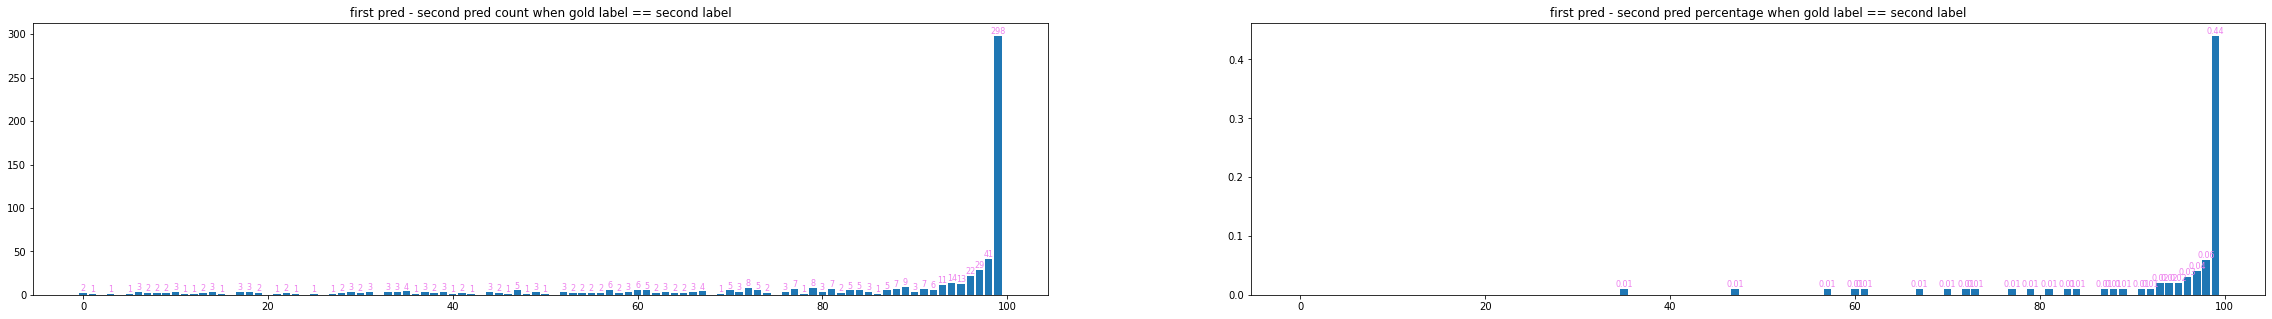

In [71]:
fig = plt.figure(figsize=(40,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(range(0,100),lam_count)
ax2.bar(range(0,100),lam_per)
for i, v in enumerate(range(0,100)):
    if lam_count[i] != 0:
        ax1.text(v, lam_count[i], lam_count[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
                 fontsize = 8, 
                 color='violet',
                 horizontalalignment='center',  # horizontalalignment (left, center, right)
                 verticalalignment='bottom')    # verticalalignment (top, center, bottom)
    if lam_per[i] != 0:
        ax2.text(v, lam_per[i], lam_per[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 8, 
             color='violet',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)
ax1.set_title('first pred - second pred count when gold label == second label')
ax2.set_title('first pred - second pred percentage when gold label == second label')
plt.show()

In [39]:
def multi_plot(tp):
    for j,l in enumerate(list(dict_label_to_num.keys())):
        nomatch_count=[]
        match_count=[]
        second_count=[]
        second_prob=[]
        second_nomatch=[]
        for i in range(0,100):
            nomatch_count.append(len(no_match[(no_match['pred_prob']>i*0.01)&\
                                            (no_match['pred_prob']<=(i+1)*0.01)&(no_match['pred_label']==l)]))
            match_count.append(len(match[(match['pred_prob']>i*0.01)&\
                                            (match['pred_prob']<=(i+1)*0.01)&(match['pred_label']==l)]))
            second_count.append(len(no_match[(no_match['pred_prob']>i*0.01)&\
                                            (no_match['pred_prob']<=(i+1)*0.01)&(no_match['second_label']==l)&(no_match['gold_label']==no_match['second_label'])]))
            second_prob.append(len(no_match[(no_match['second_prob']>i*0.01)&\
                                            (no_match['second_prob']<=(i+1)*0.01)&(no_match['second_label']==l)&(no_match['gold_label']==no_match['second_label'])]))
            second_nomatch.append(len(no_match[(no_match['second_prob']>i*0.01)&\
                                            (no_match['second_prob']<=(i+1)*0.01)&(no_match['second_label']==l)&(no_match['gold_label']!=no_match['second_label'])]))
        if sum(nomatch_count)>0:
            nomatch_per =list(map(lambda x: round(x/sum(nomatch_count),2),nomatch_count))
        if sum(match_count)>0:
            match_per =list(map(lambda x: round(x/sum(match_count),2),match_count))
        if sum(second_count)>0:
            second_per =list(map(lambda x: round(x/sum(second_count),2),second_count))
        if sum(second_prob)>0:
            second_prob_per =list(map(lambda x: round(x/sum(second_prob),2),second_prob))
        if sum(second_nomatch)>0:
            second_nomatch_per =list(map(lambda x: round(x/sum(second_nomatch),2),second_nomatch))
        x = range(0,100)
        fig = plt.figure(figsize=(40,240))
        gs = gridspec.GridSpec(30,5)
        for k in range(5):
            ax = fig.add_subplot(gs[j,k])
            if k==0:
                if tp=='count':
                    y = match_count
                elif tp=='perc':
                    y = match_per
                title = 'match'
            elif k==1:
                if tp=='count':
                    y = nomatch_count
                elif tp=='perc':
                    y = nomatch_per
                title = 'nomatch'
            elif k==2:
                if tp=='count':
                    y = second_count
                elif tp=='perc':
                    y = second_per
                title = 'pred-prob_match-second'
            elif k==3:
                if tp =='count':
                    y = second_prob
                elif tp=='perc':
                    y = second_prob_per
                title = 'second-prob_match-second'
            elif k==4:
                if tp =='count':
                    y = second_nomatch
                elif tp=='perc':
                    y = second_nomatch_per
                title = 'second-prob_nomatch-second'
            ax.bar(x,y)
            ax.set_title('{}_{}_{}'.format(l,title,tp))
            ax.set_xticks(range(0,100,5))
            for i, v in enumerate(x):
                if y[i] != 0:
                    ax.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
                            fontsize = 8, 
                            color='violet',
                            horizontalalignment='center',  # horizontalalignment (left, center, right)
                            verticalalignment='bottom')    # verticalalignment (top, center, bottom)
        fig.align_labels()
    plt.show()
    # fig.savefig('../src/{}.png'.format(tp))

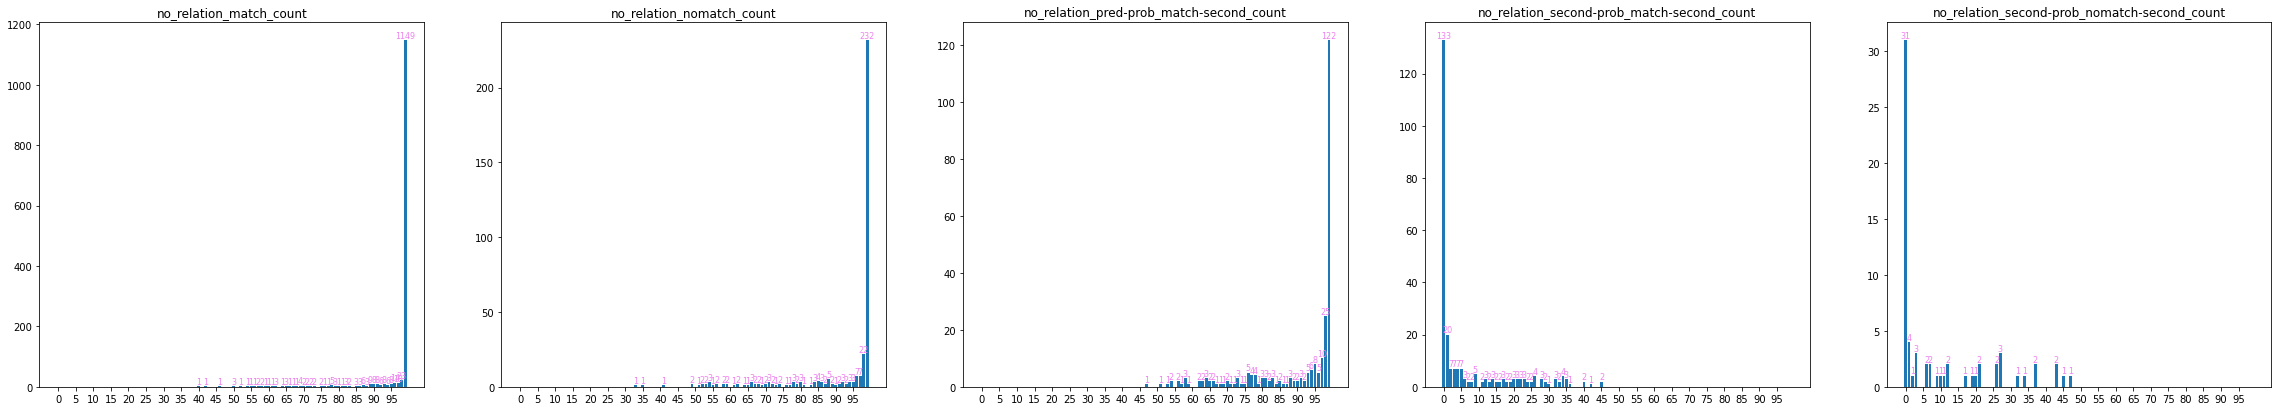

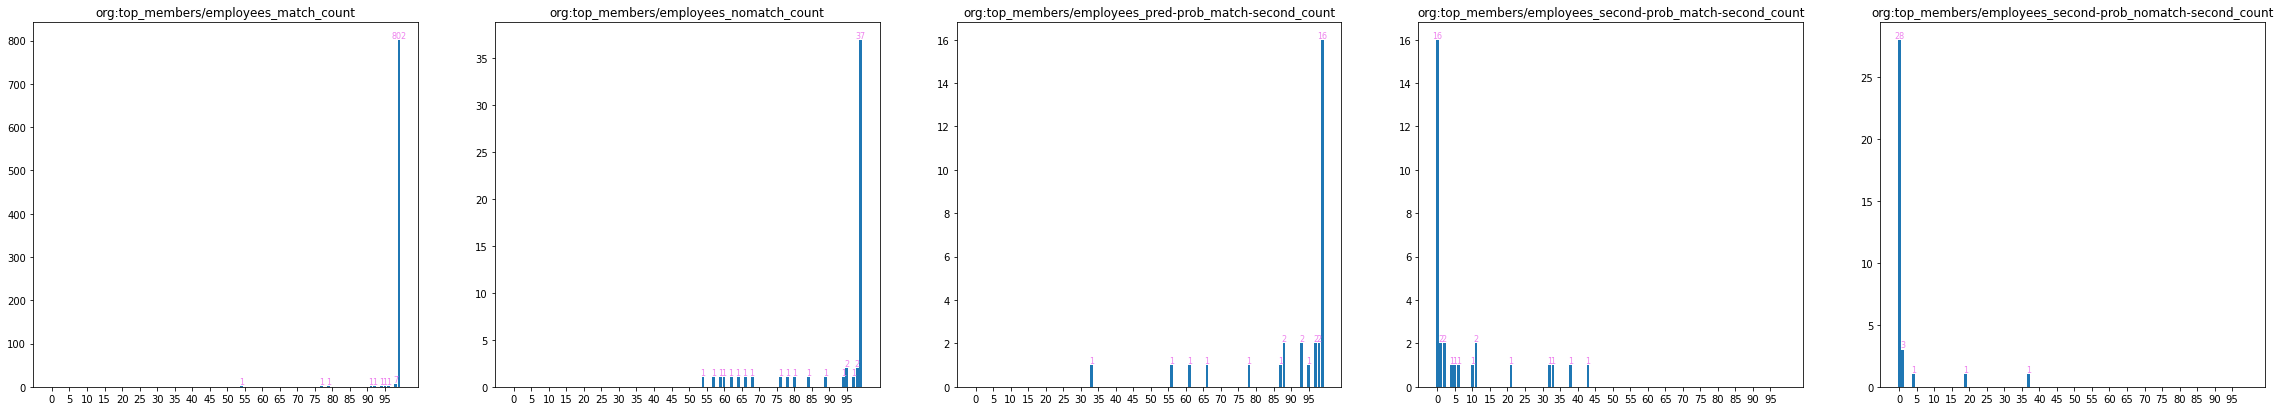

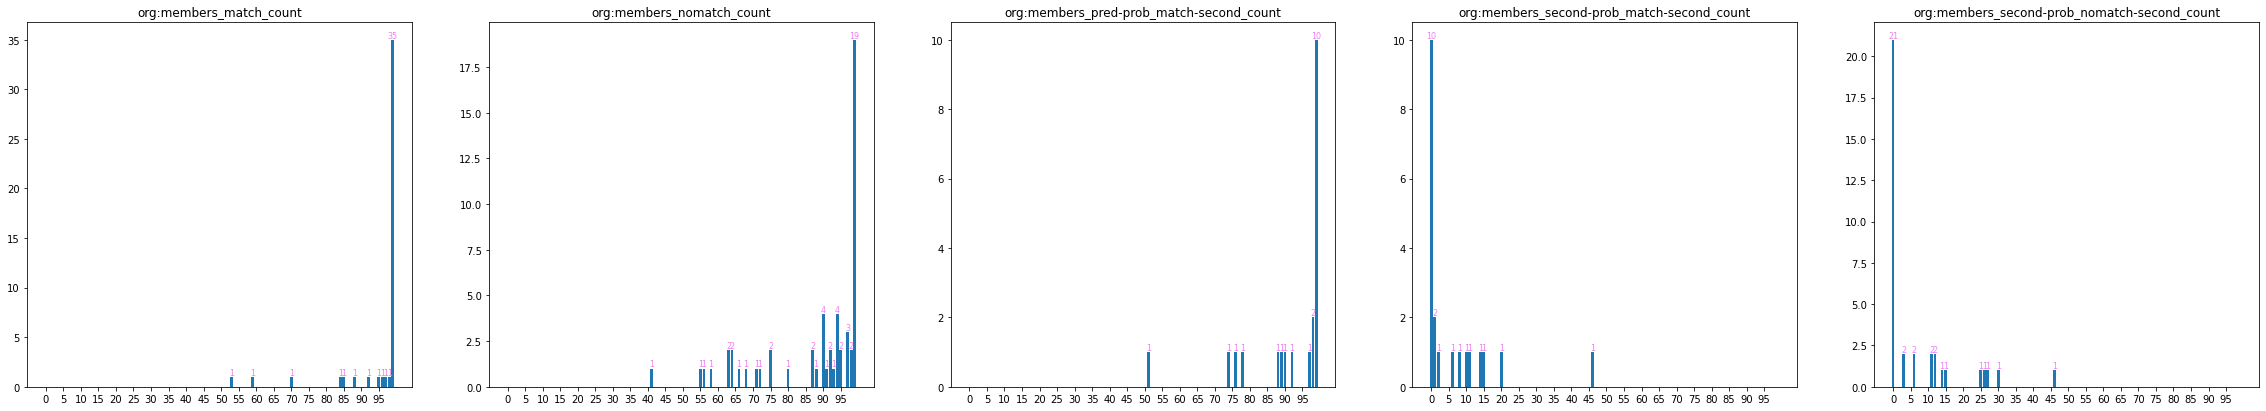

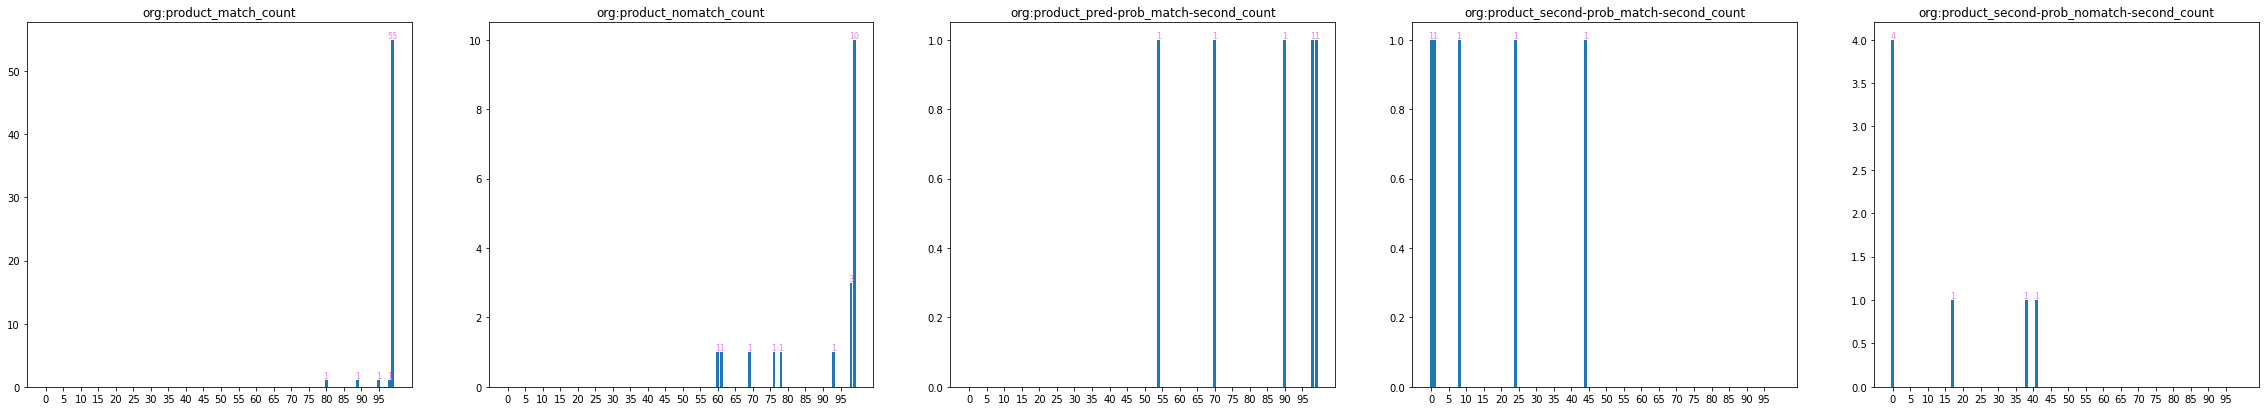

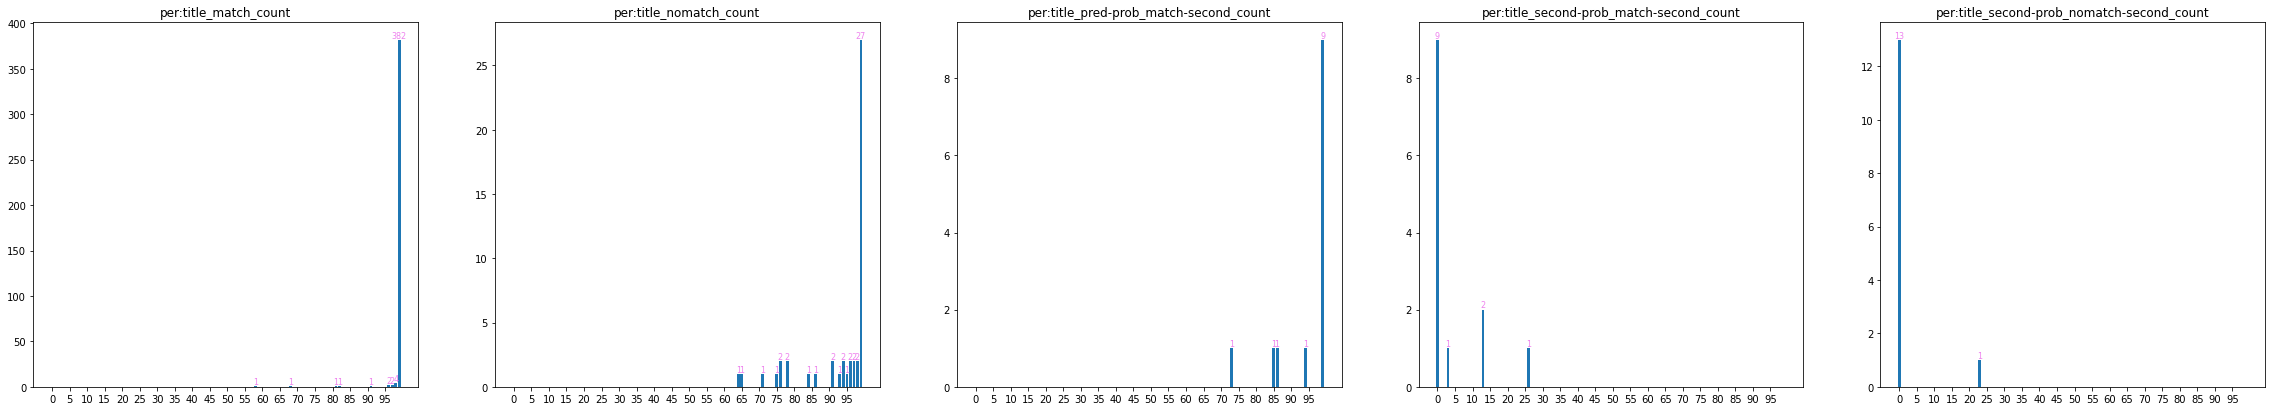

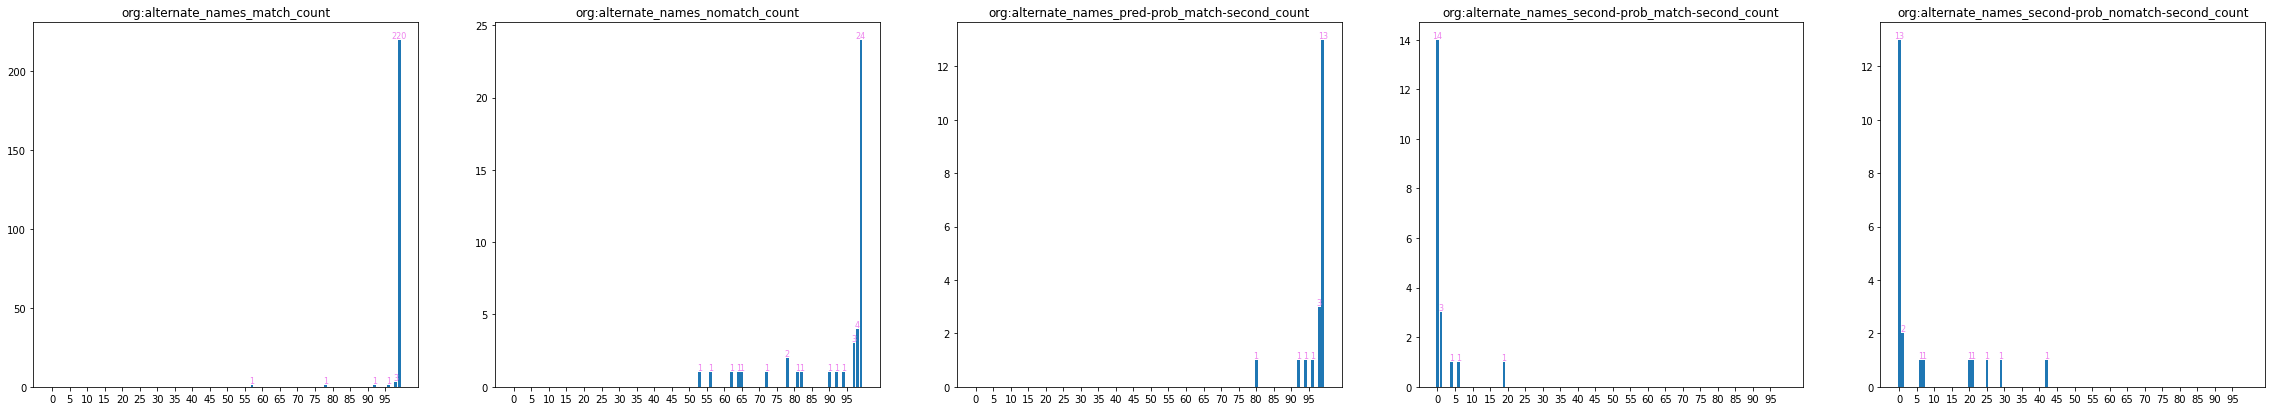

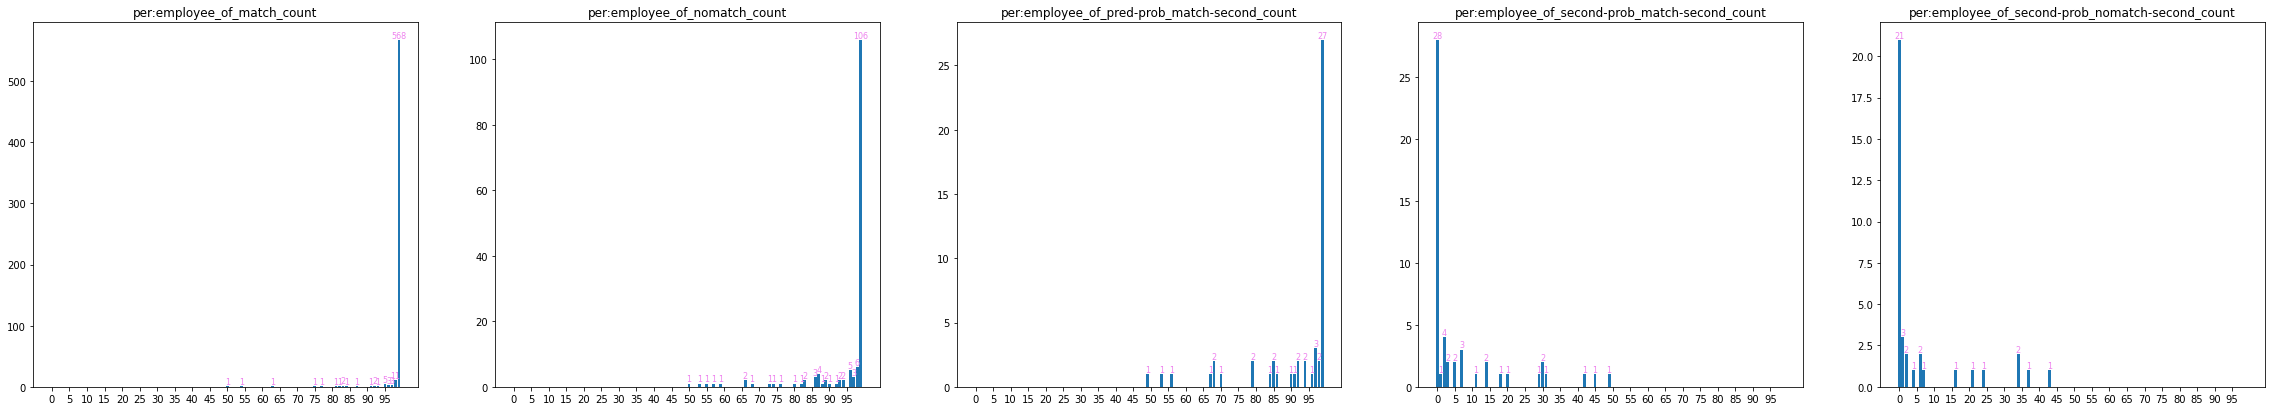

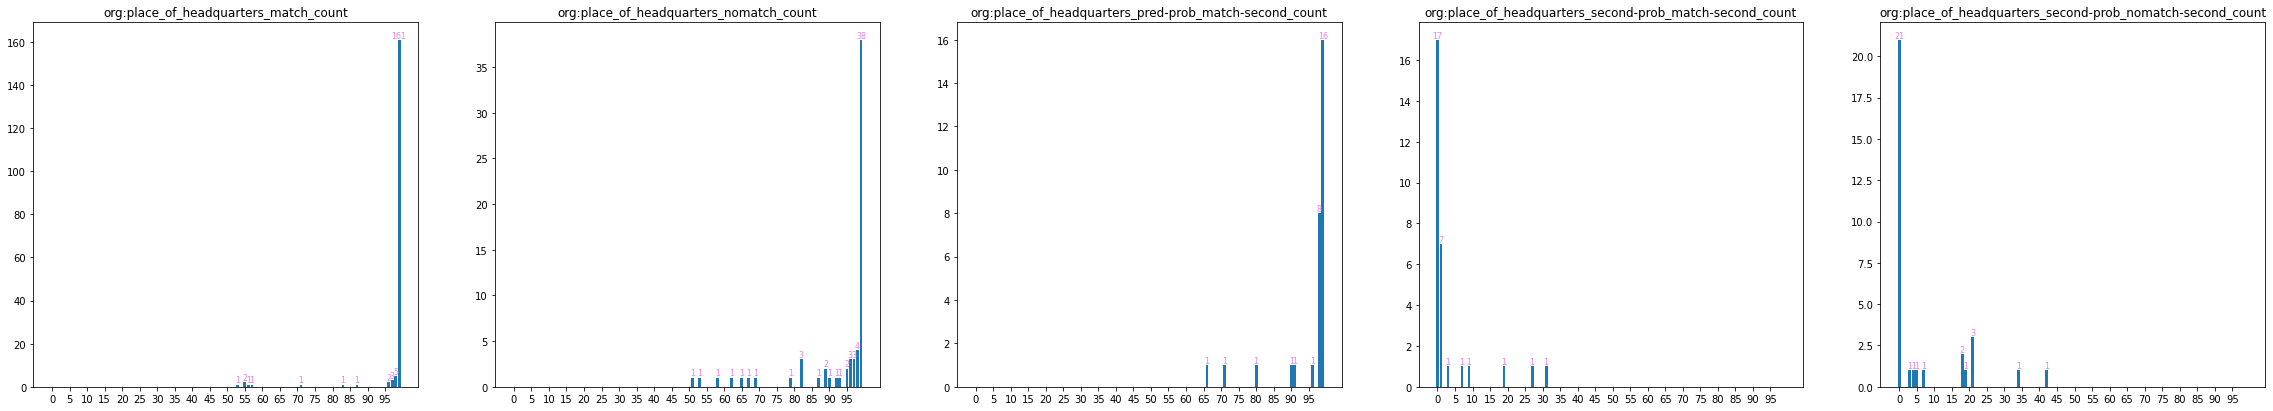

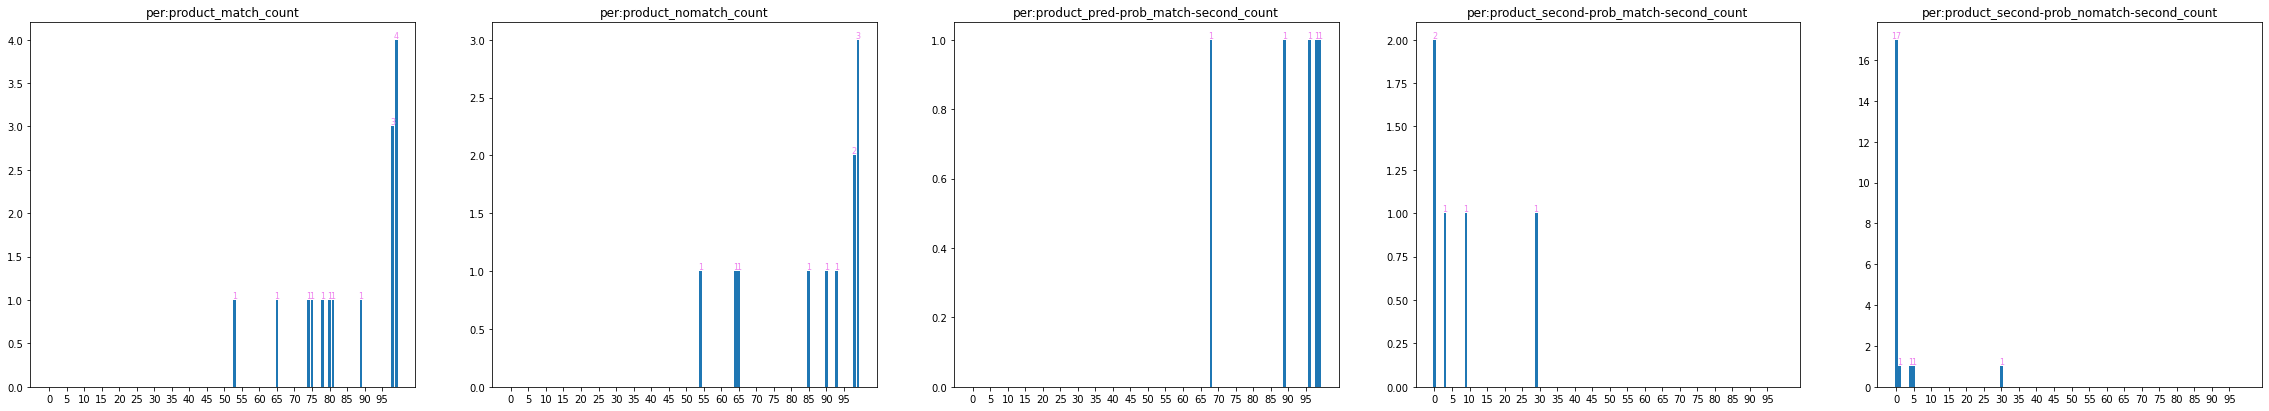

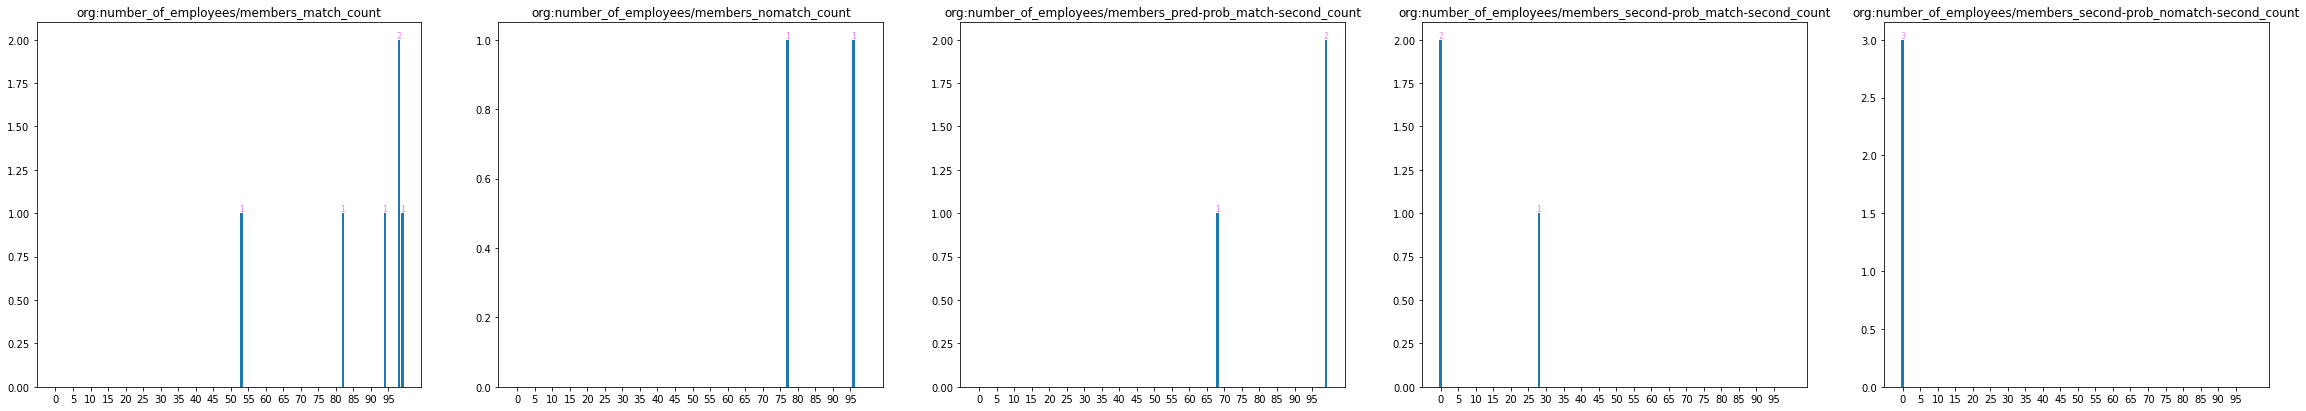

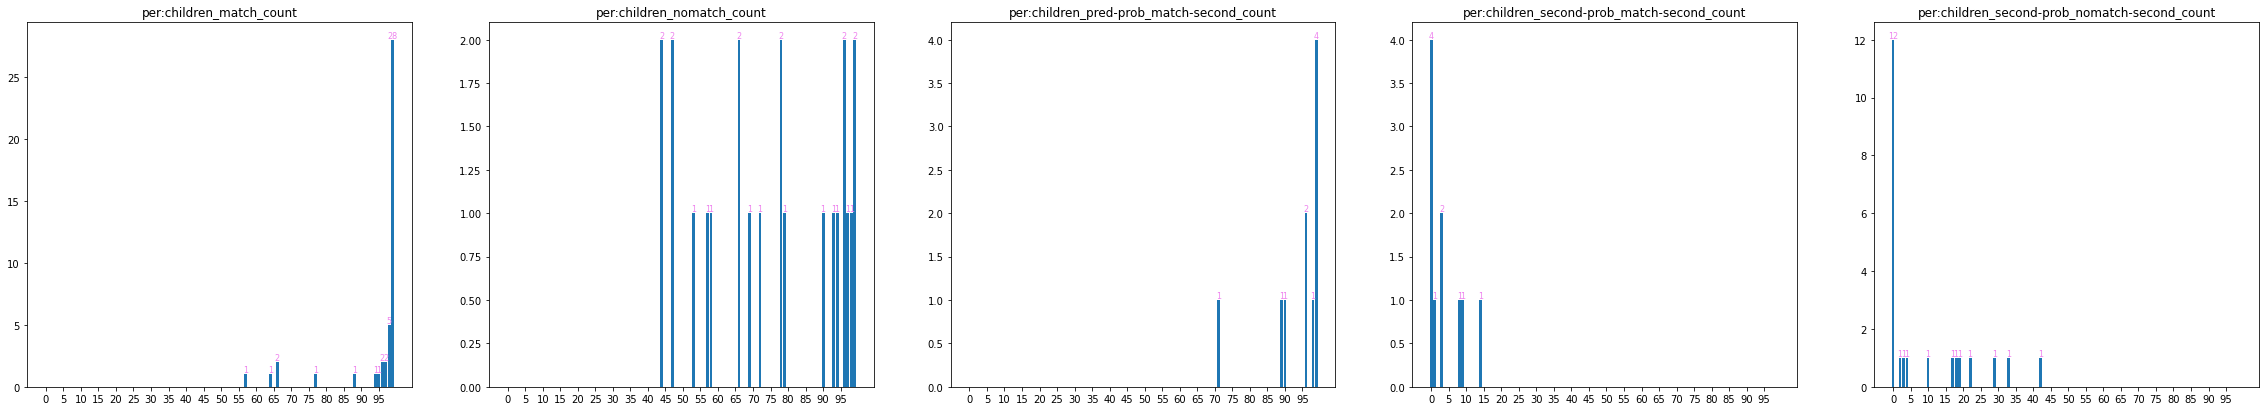

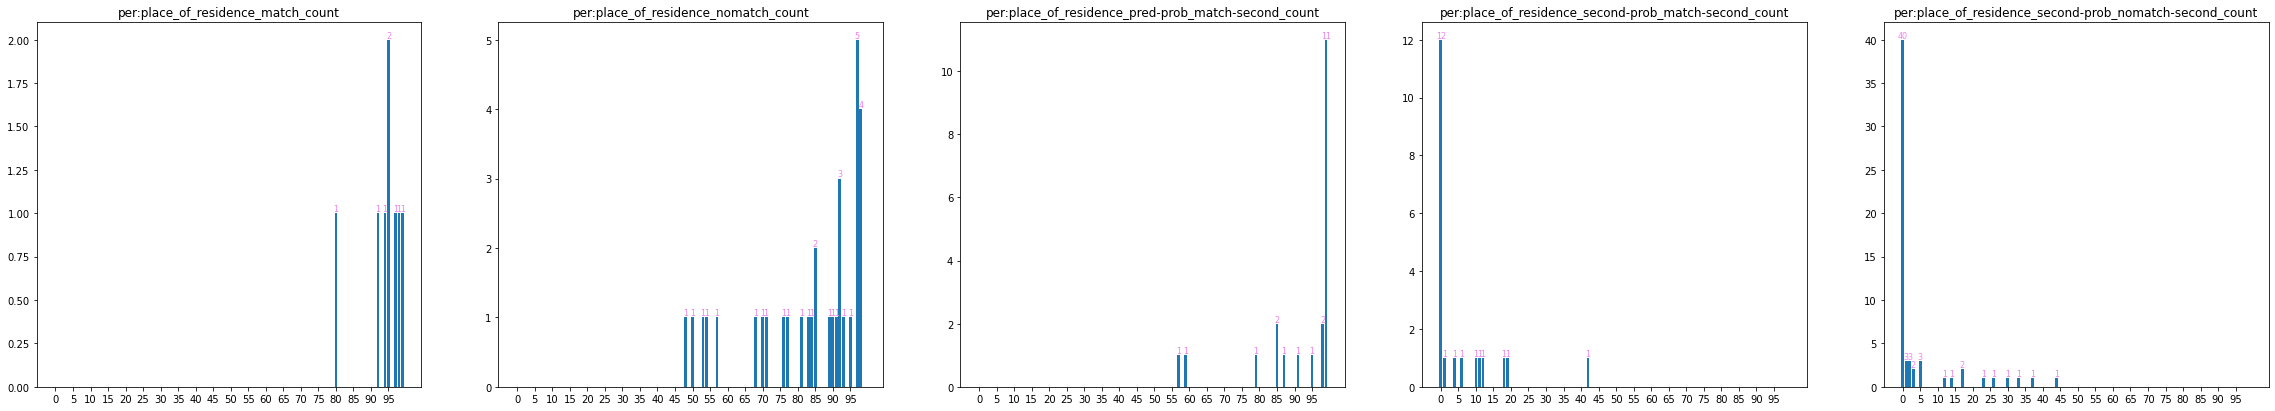

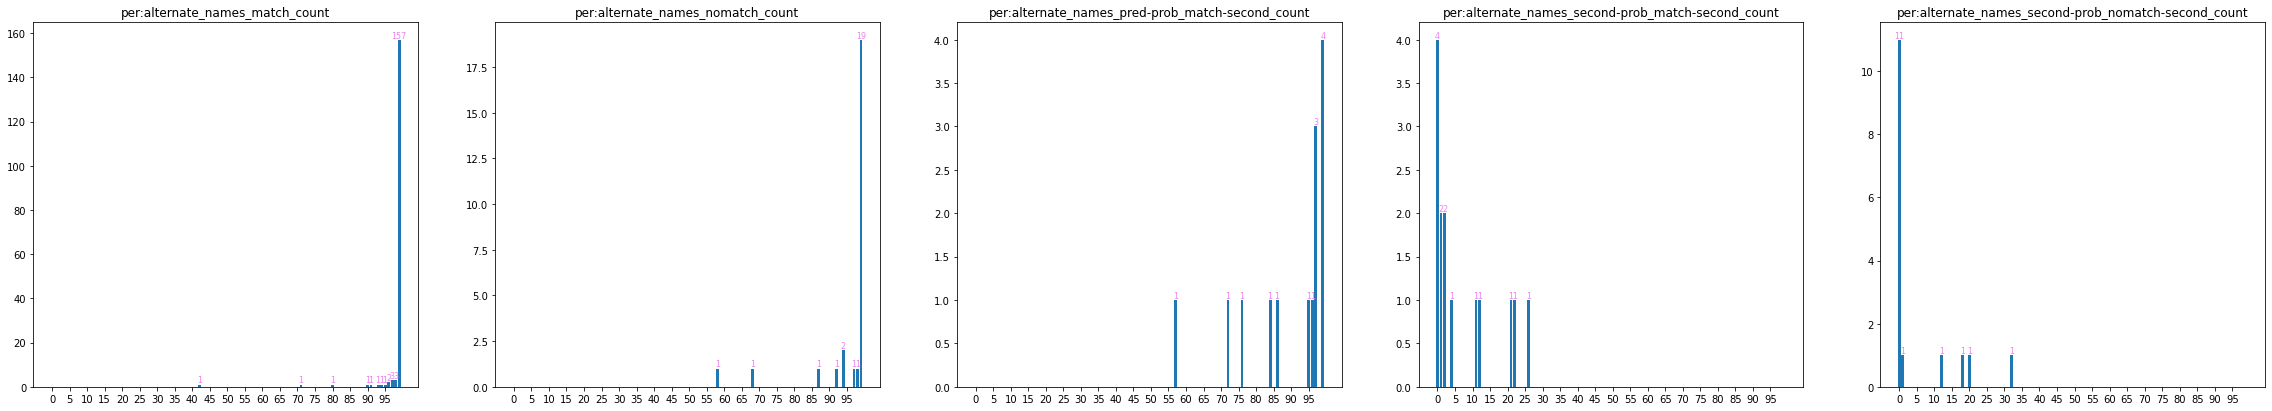

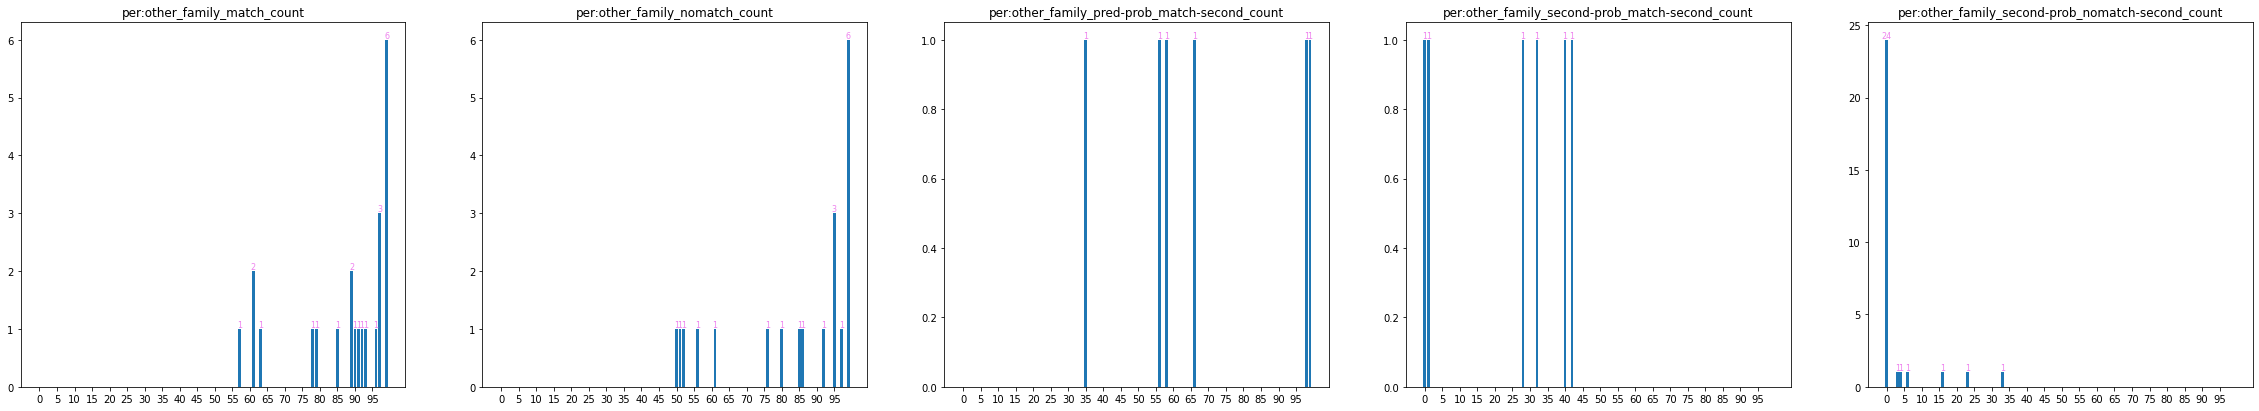

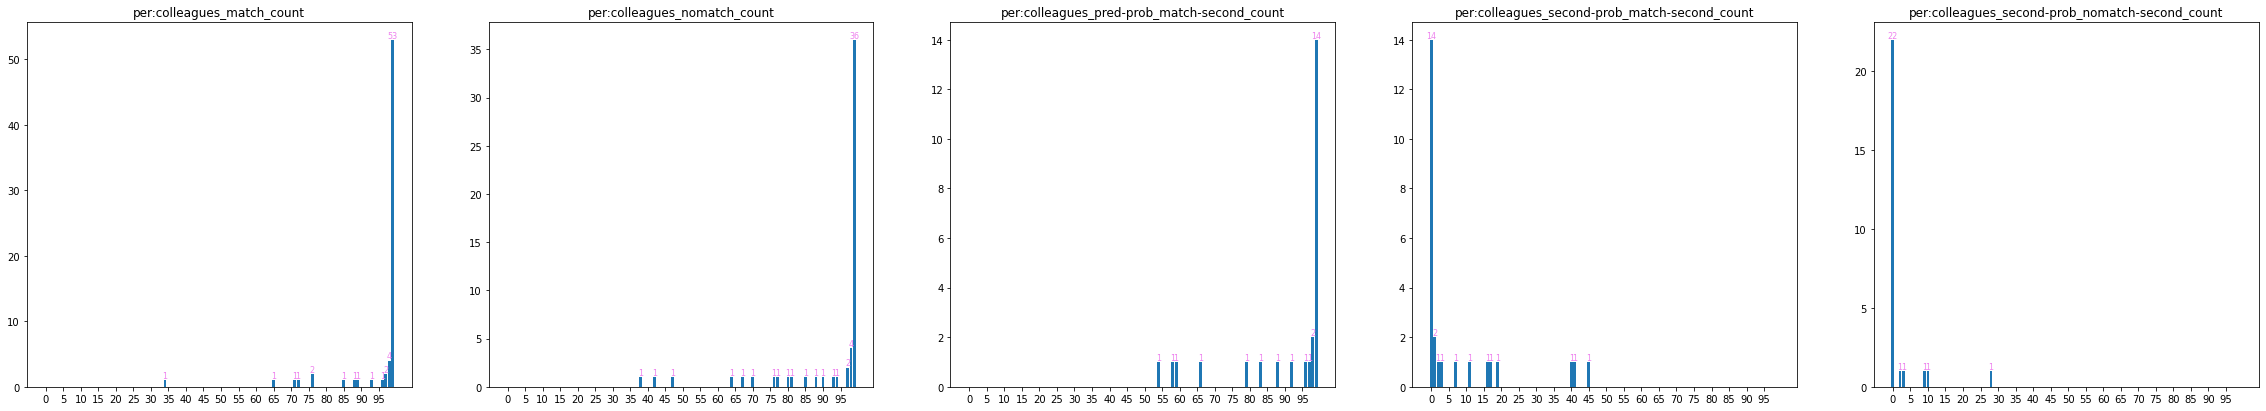

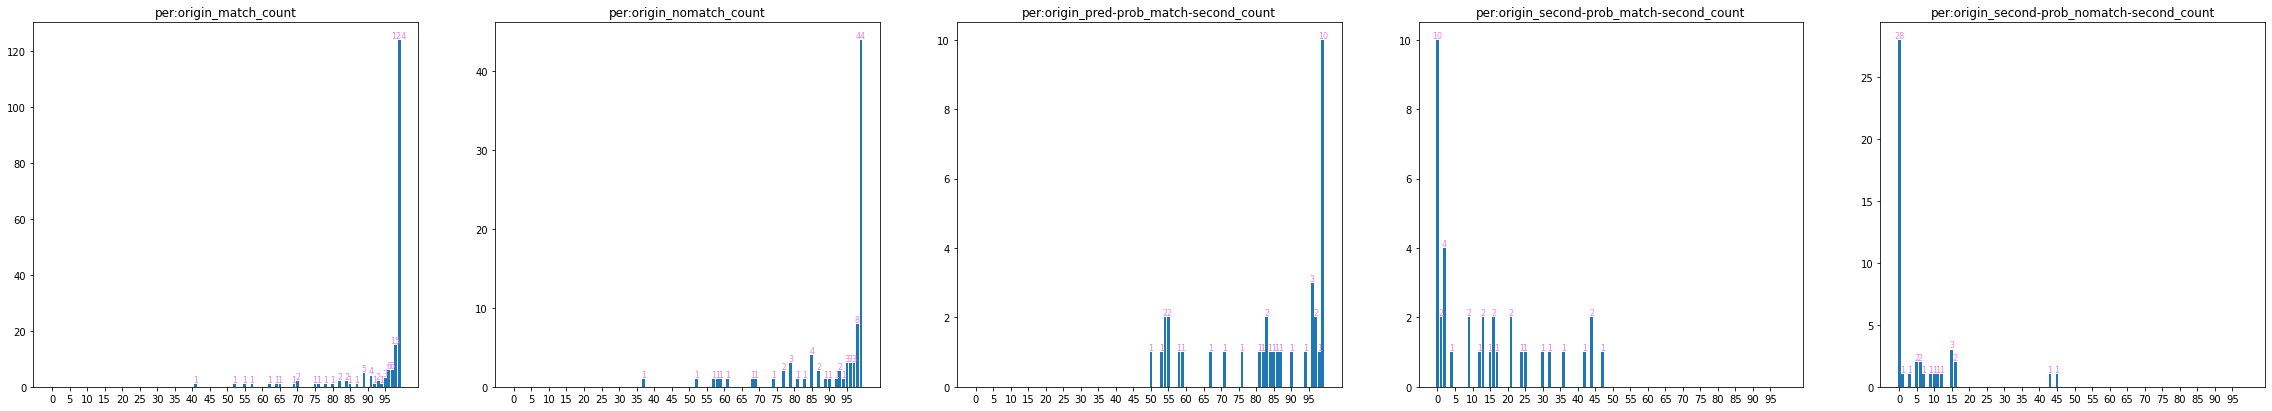

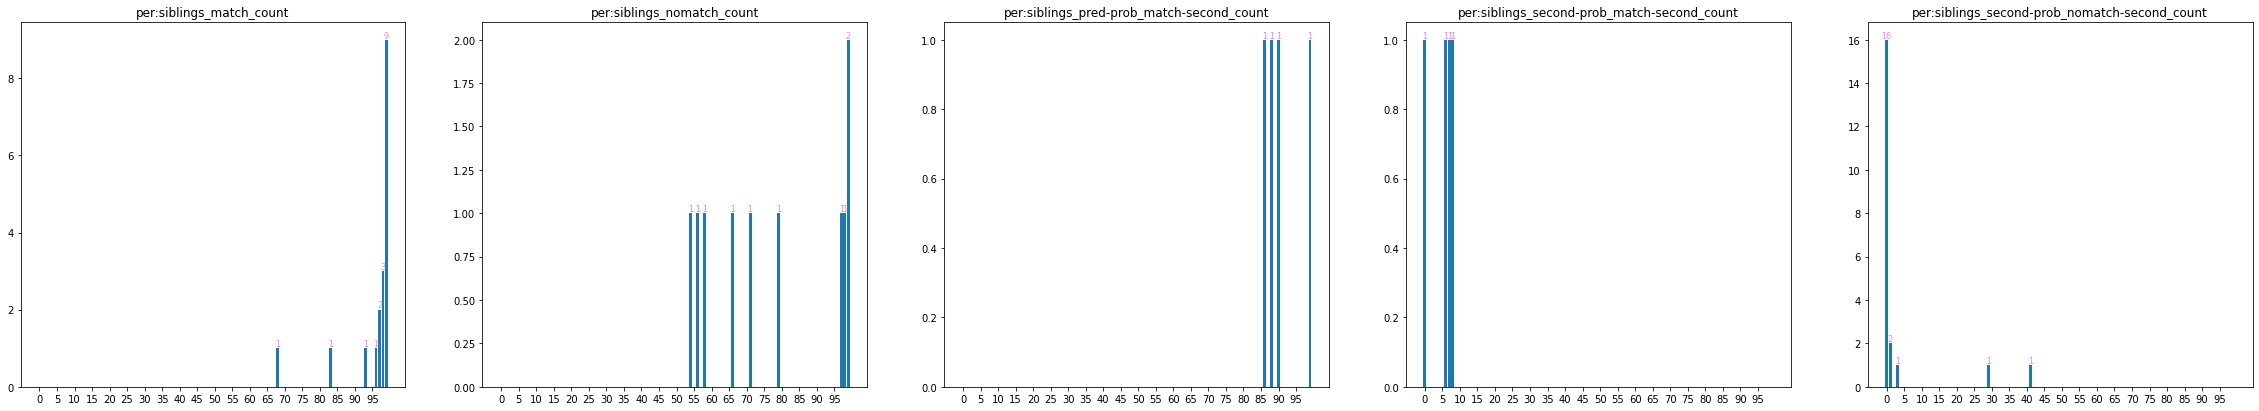

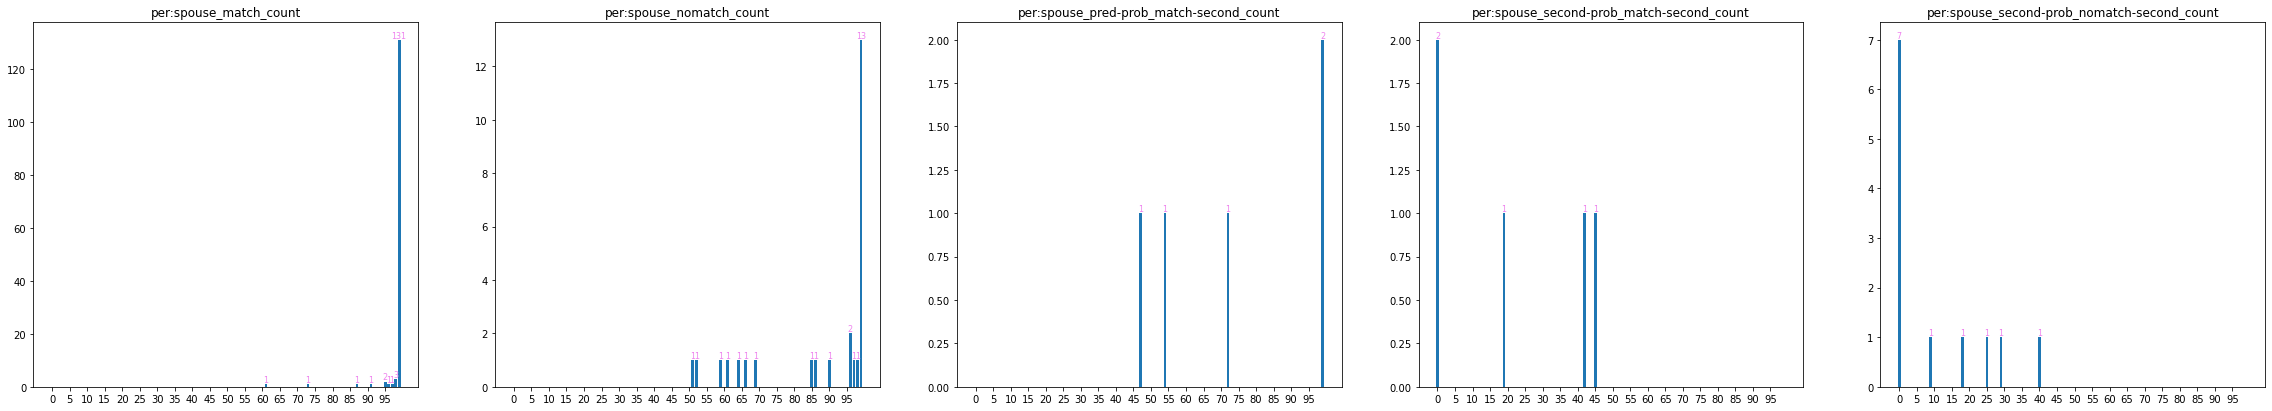

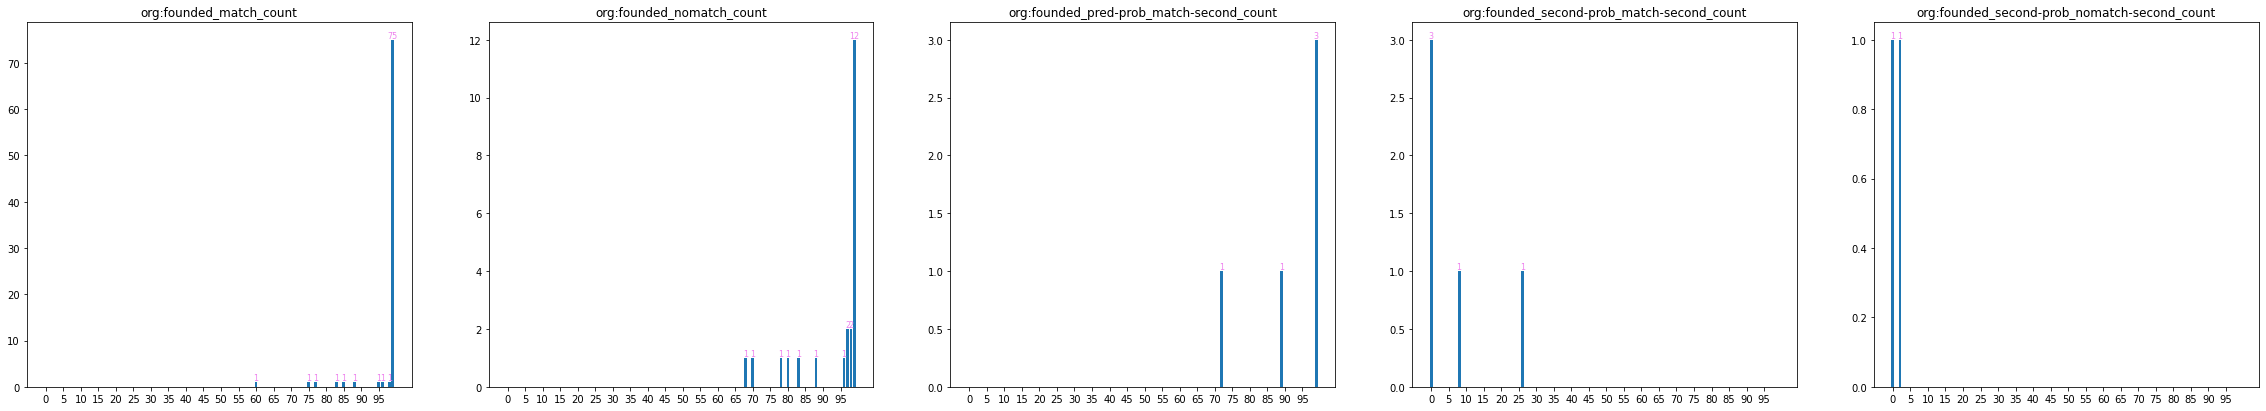

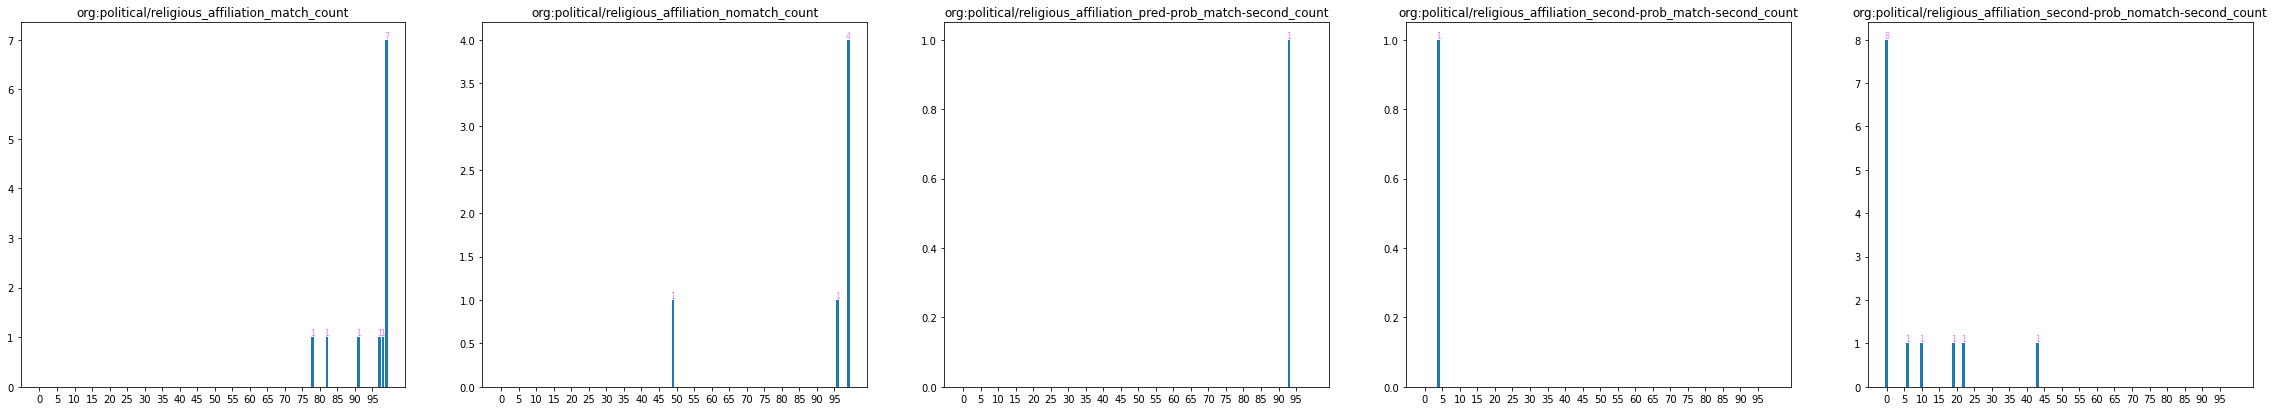

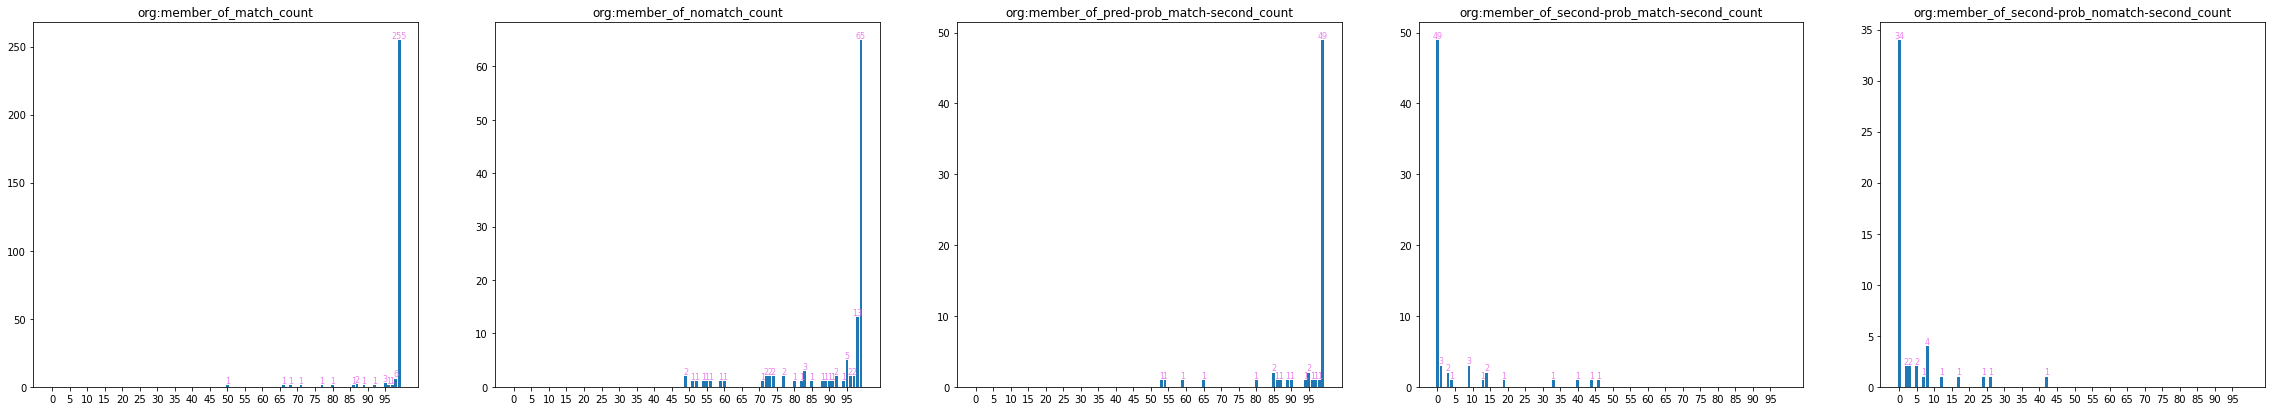

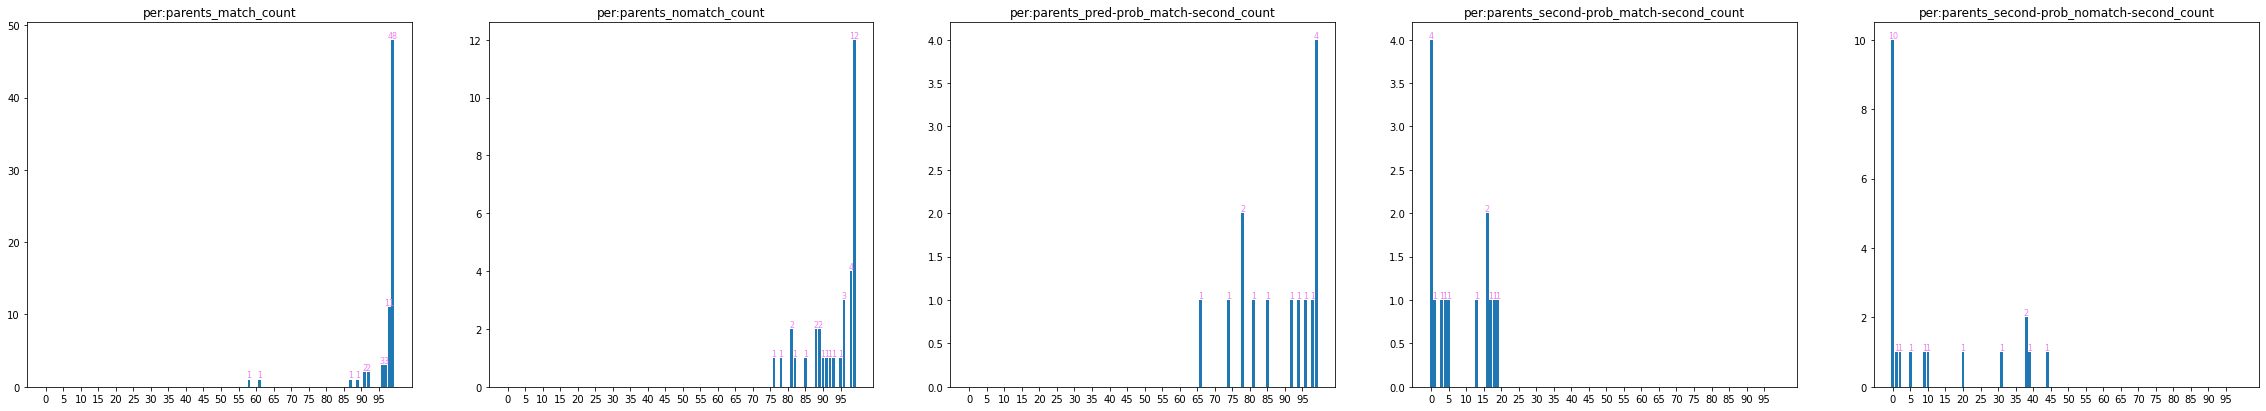

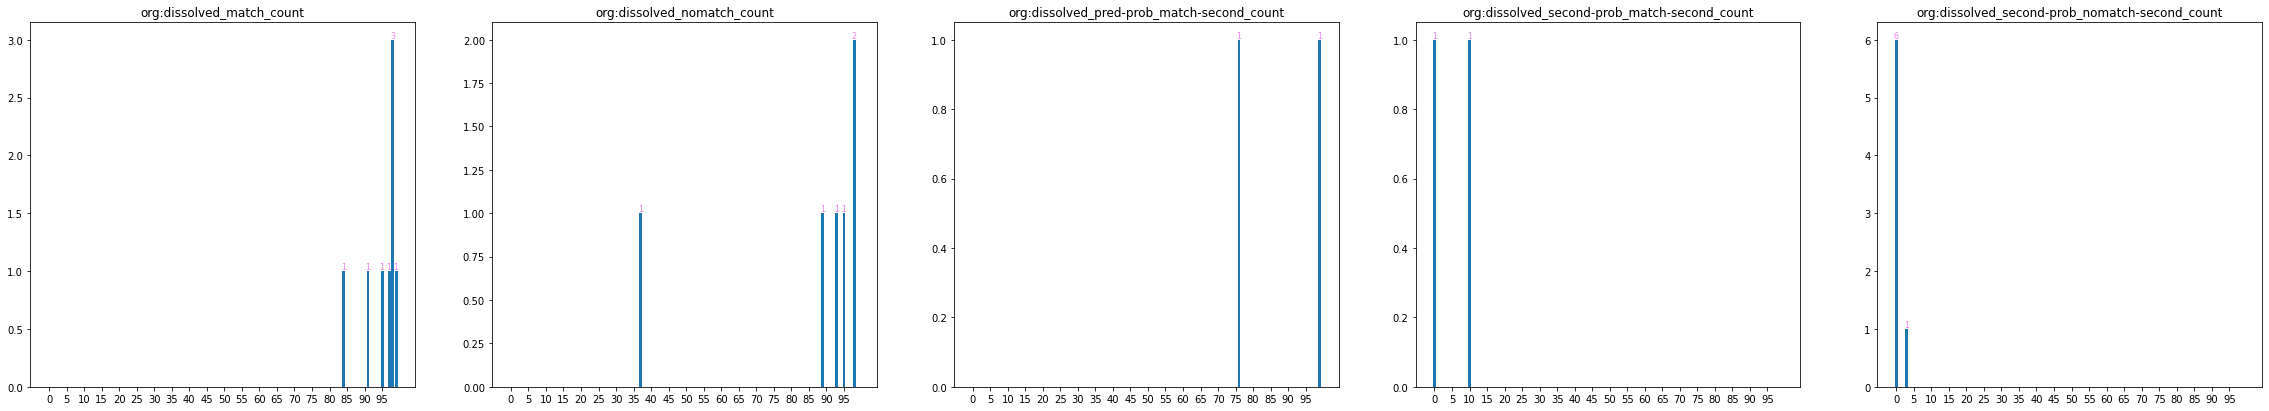

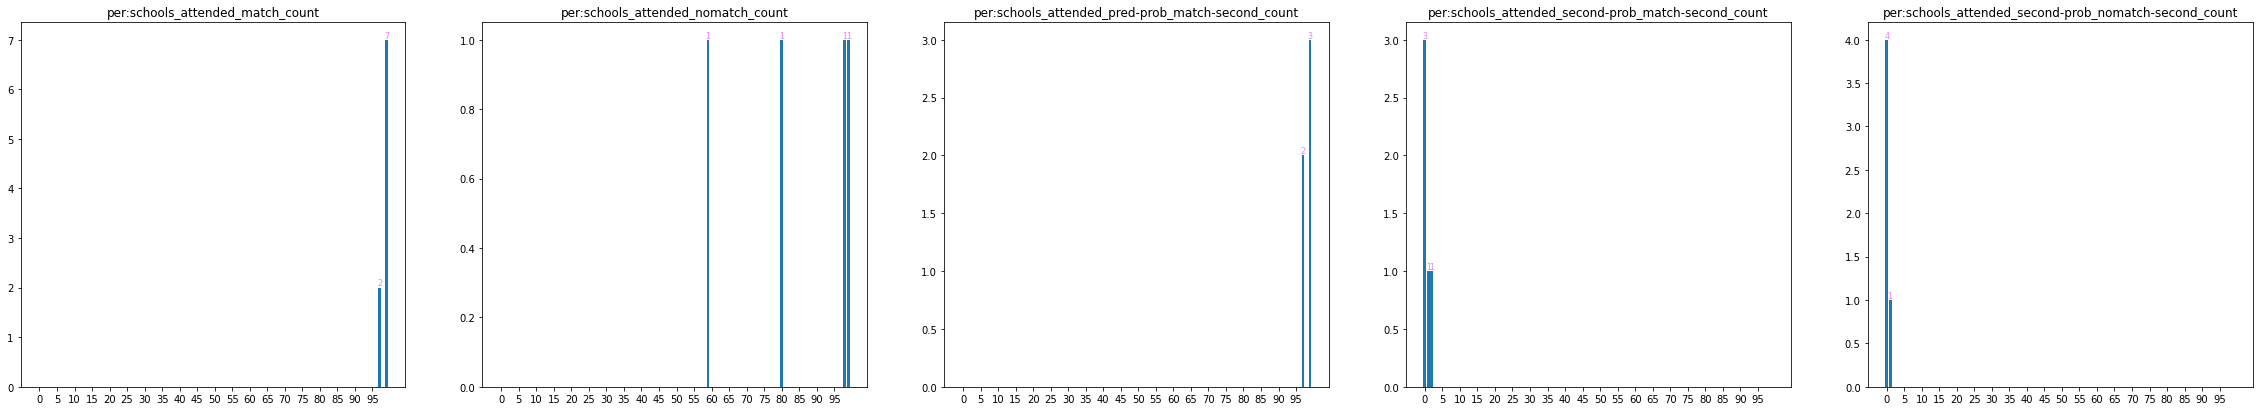

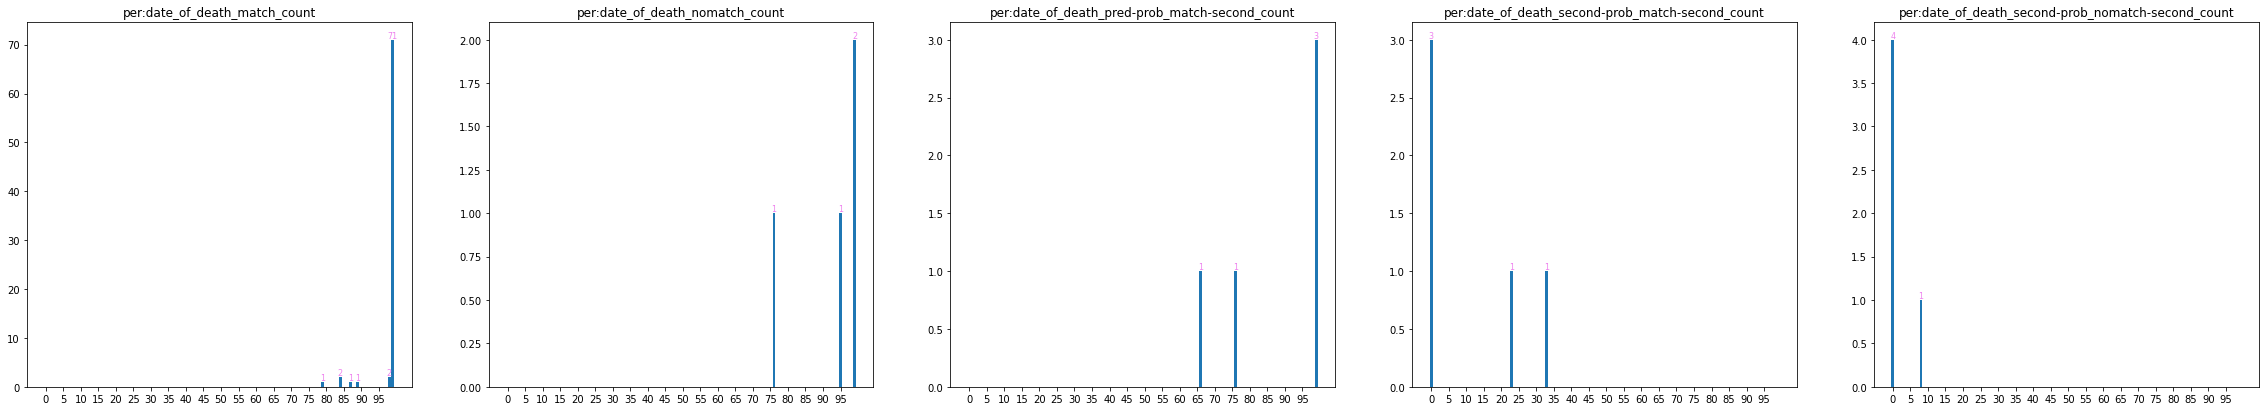

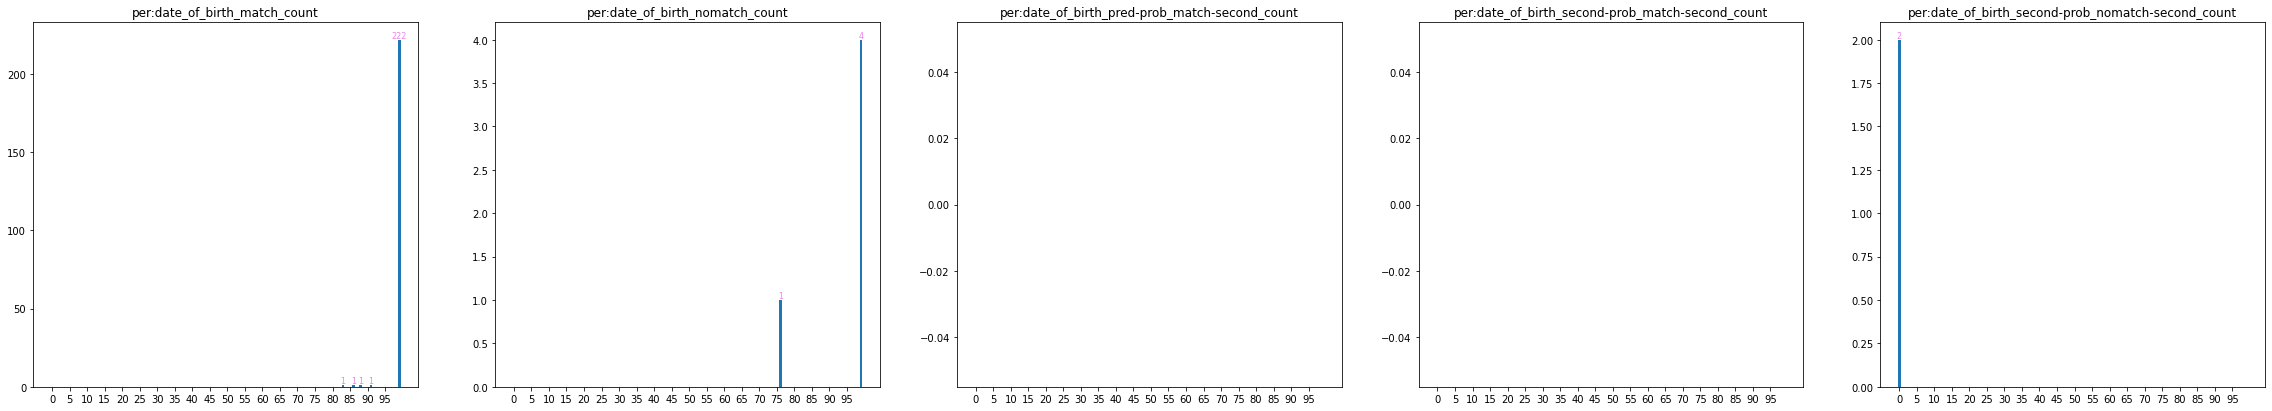

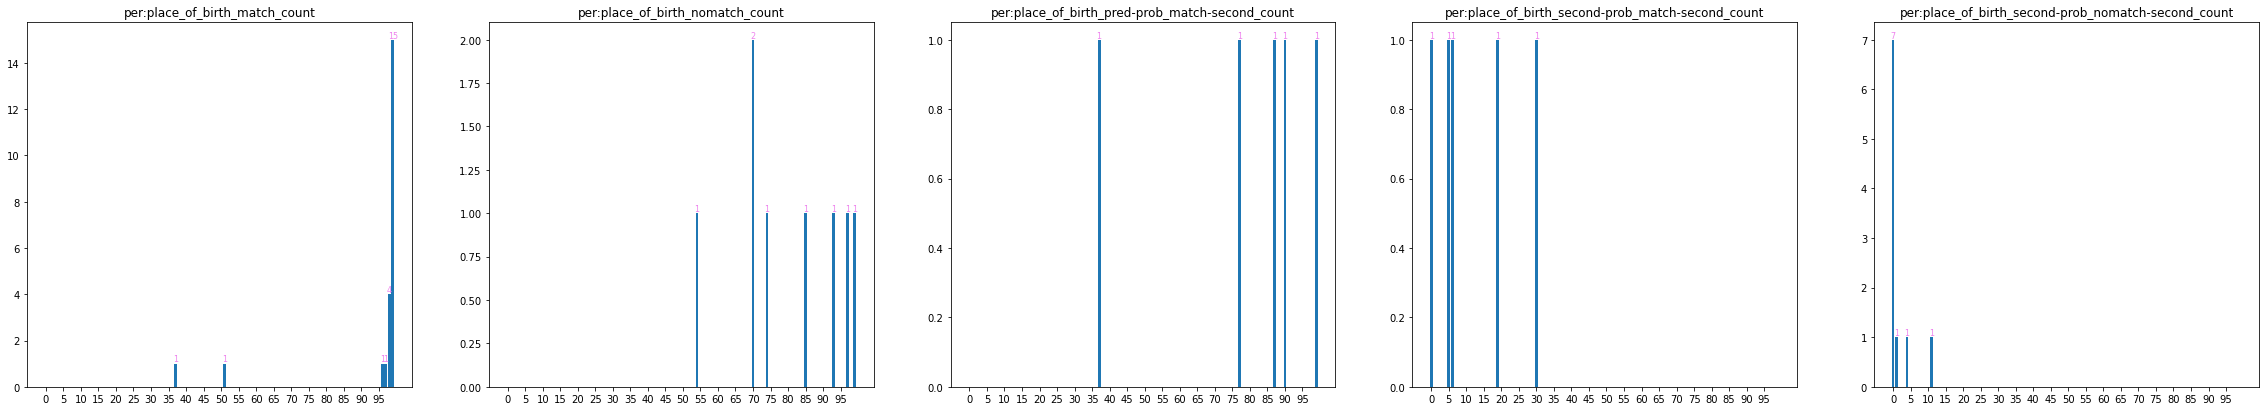

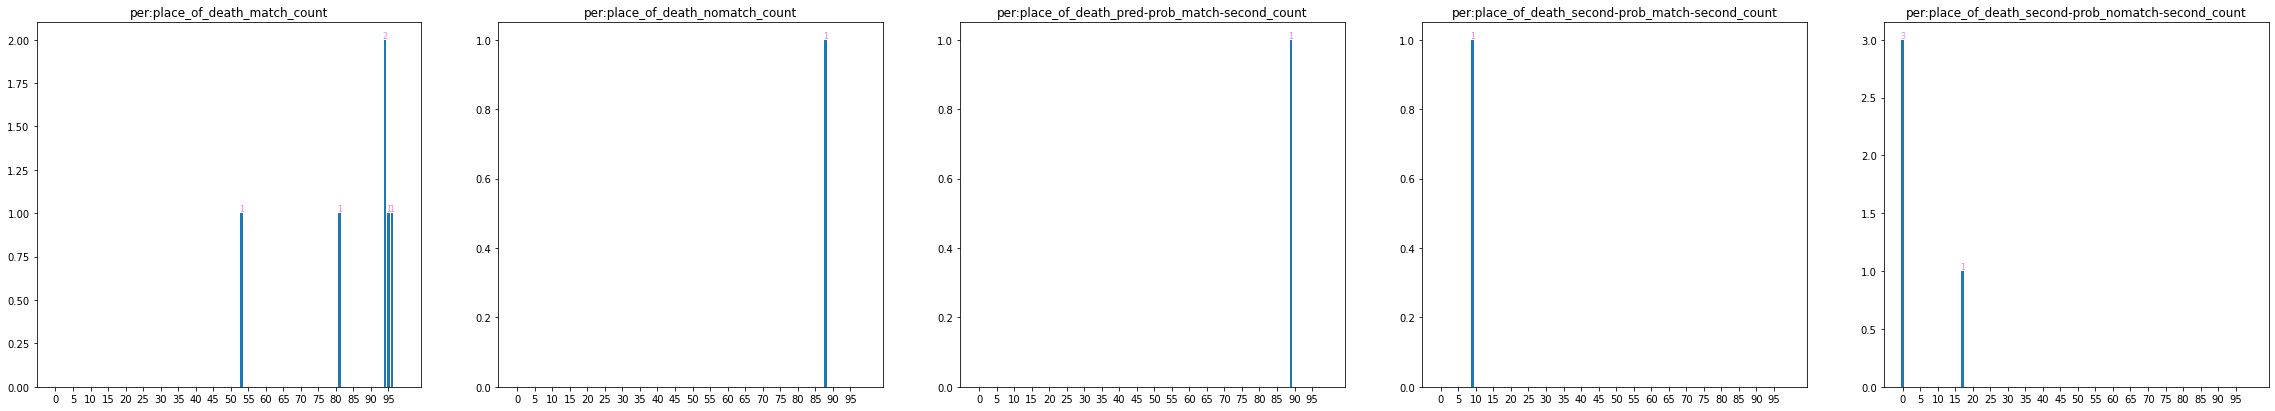

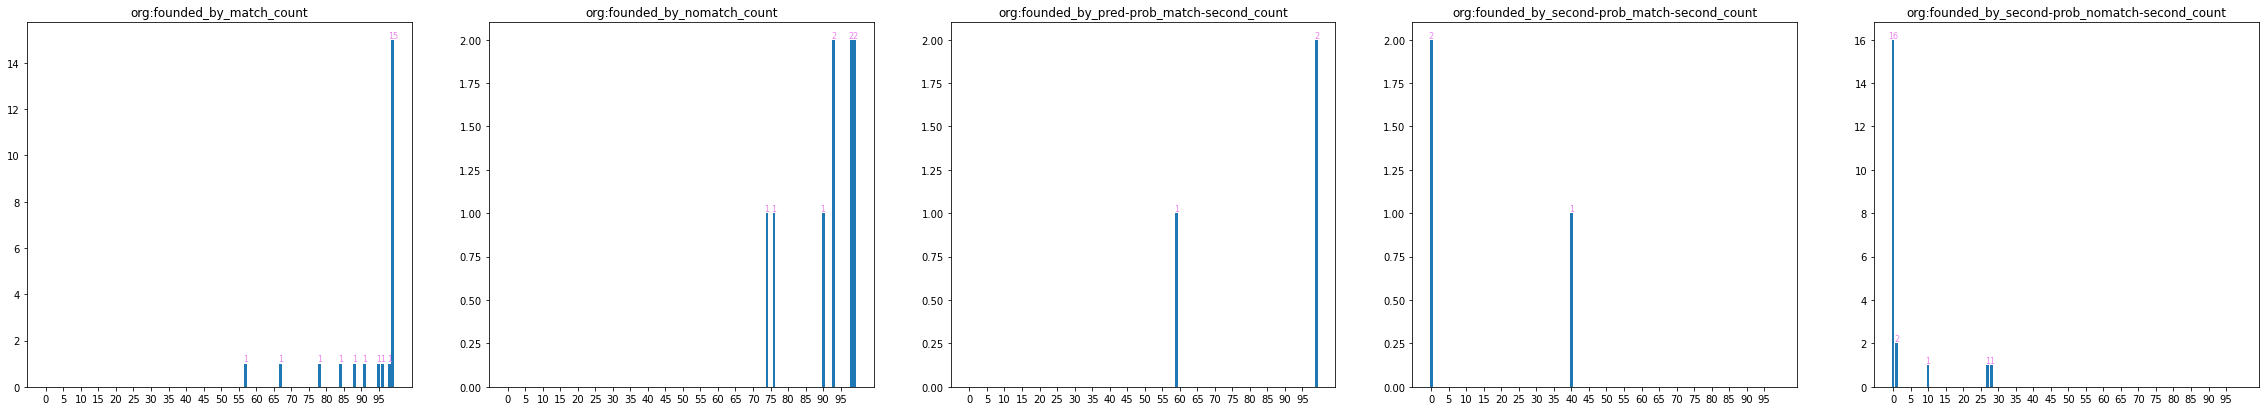

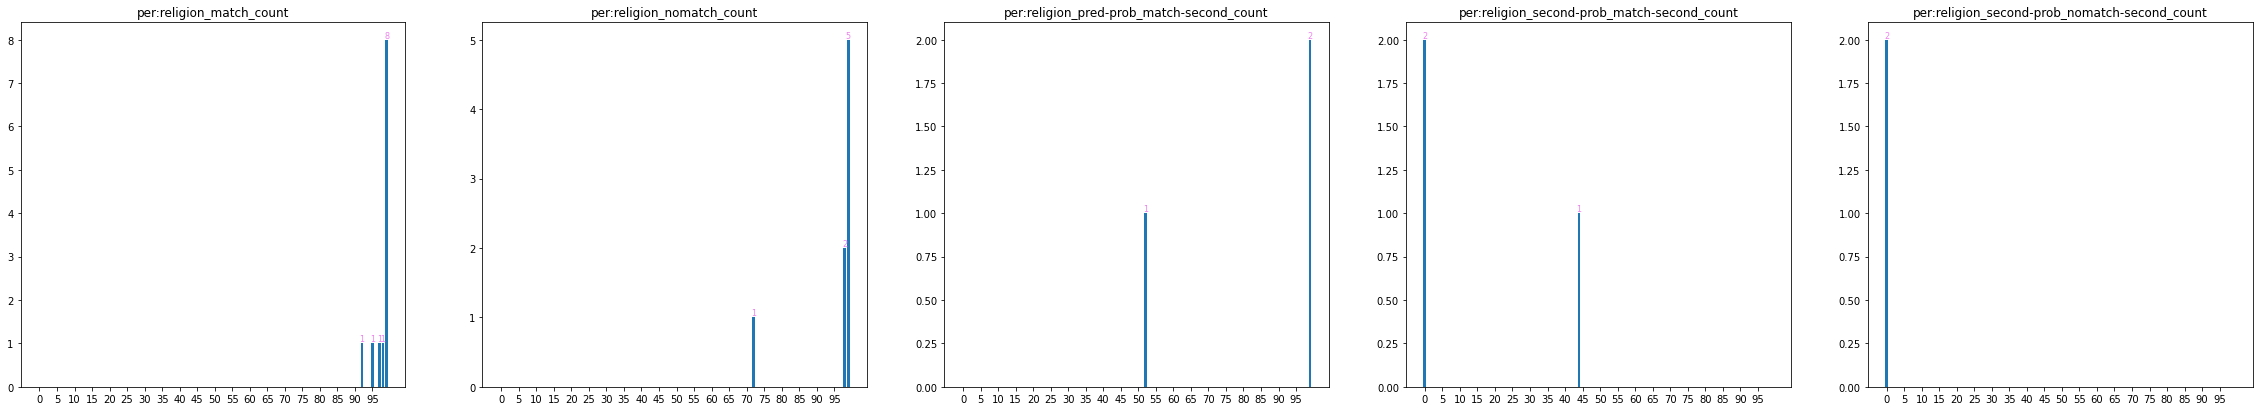

In [40]:
multi_plot('count')

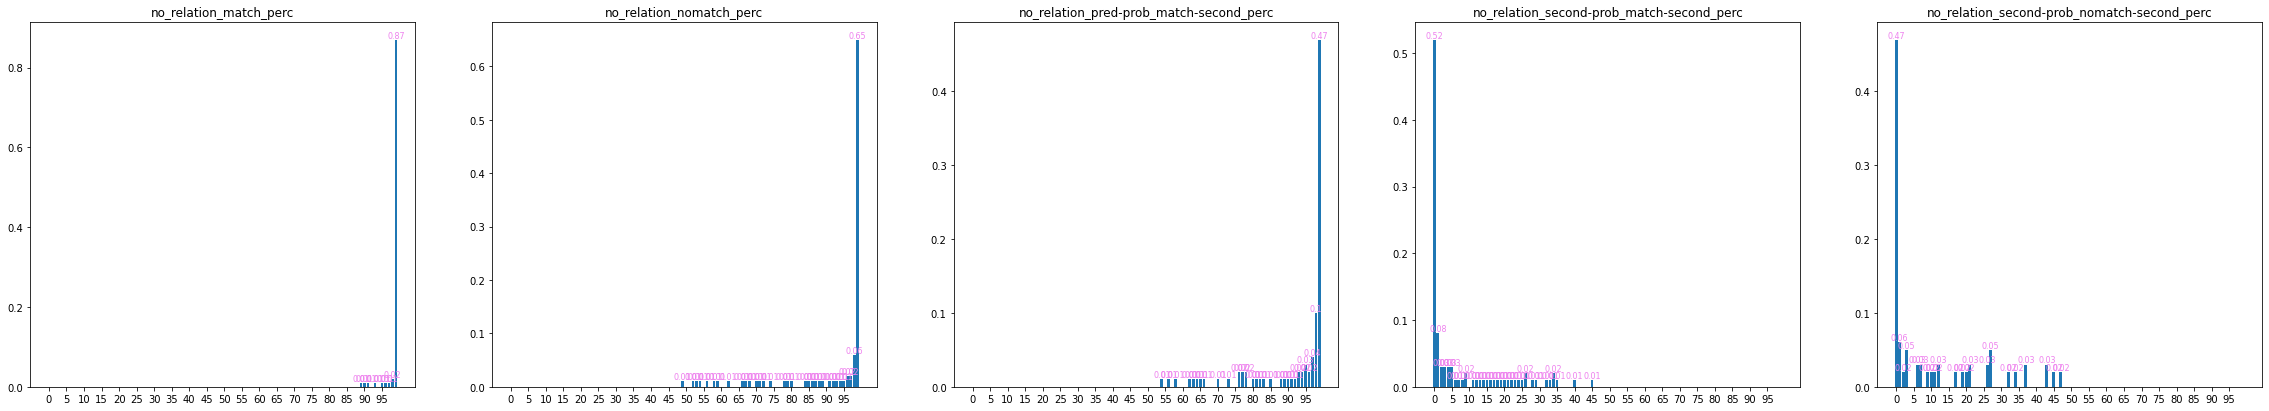

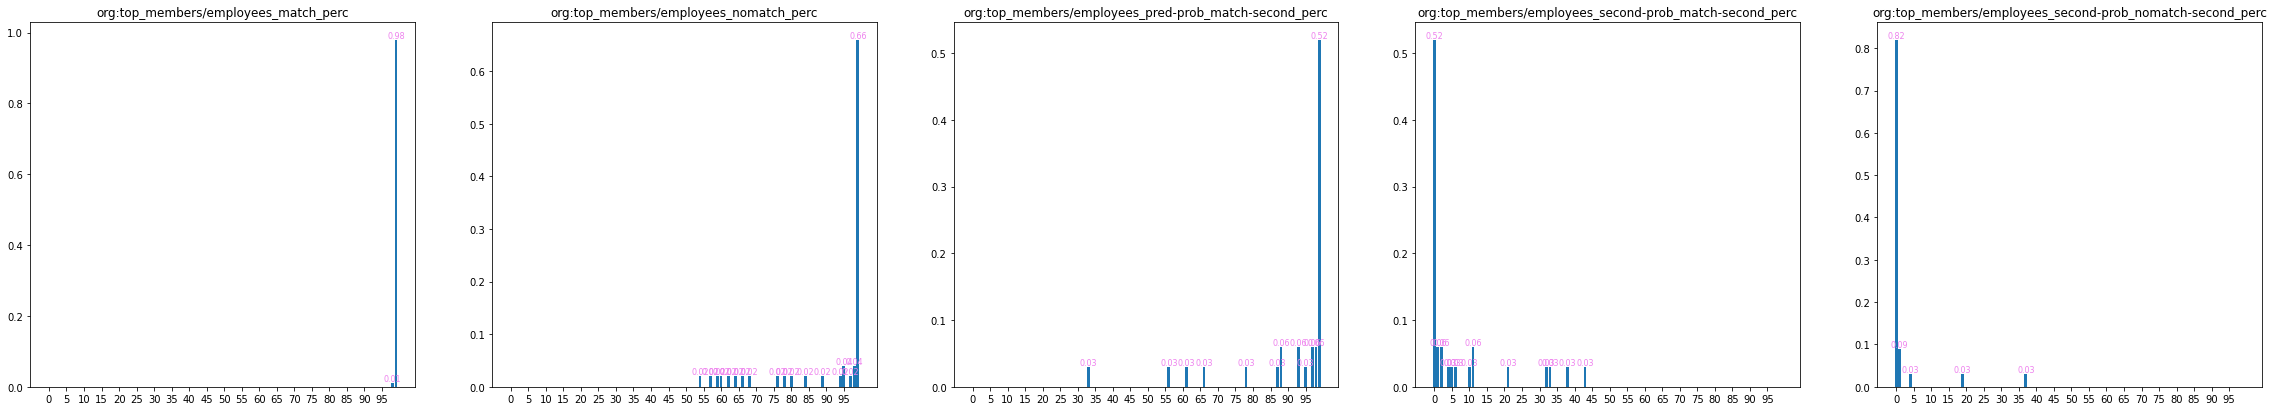

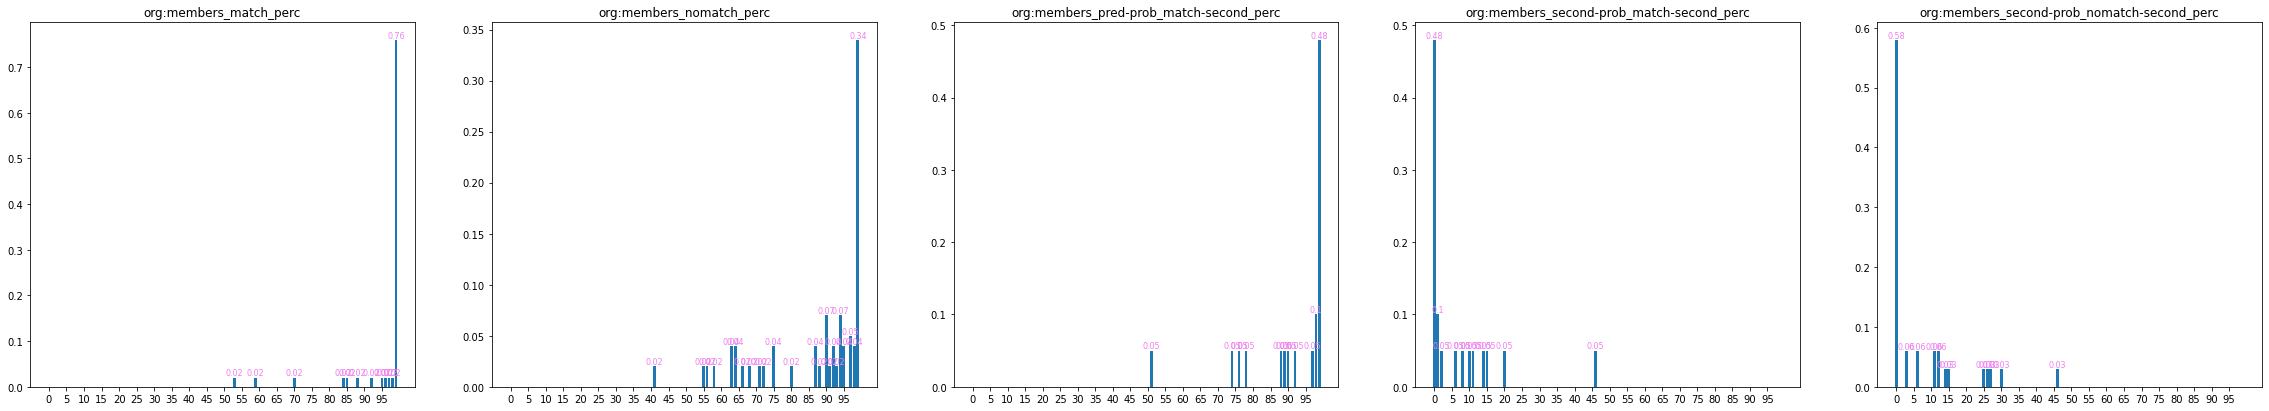

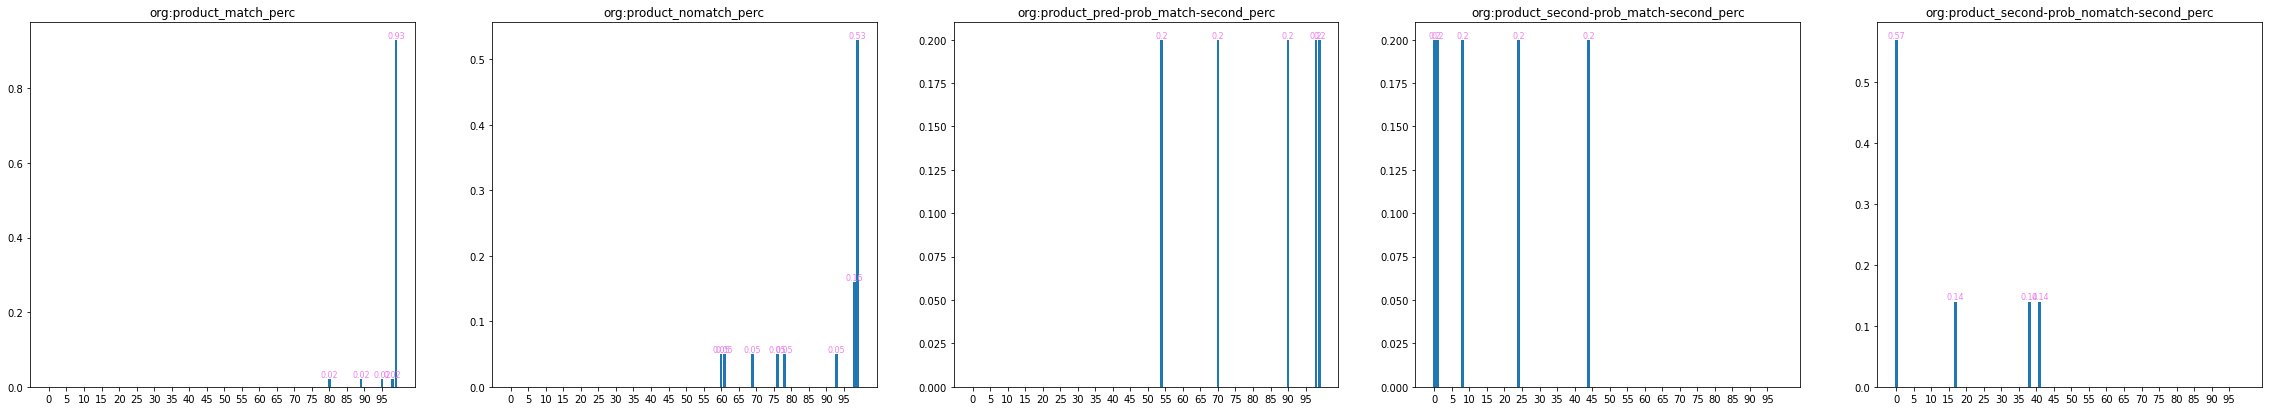

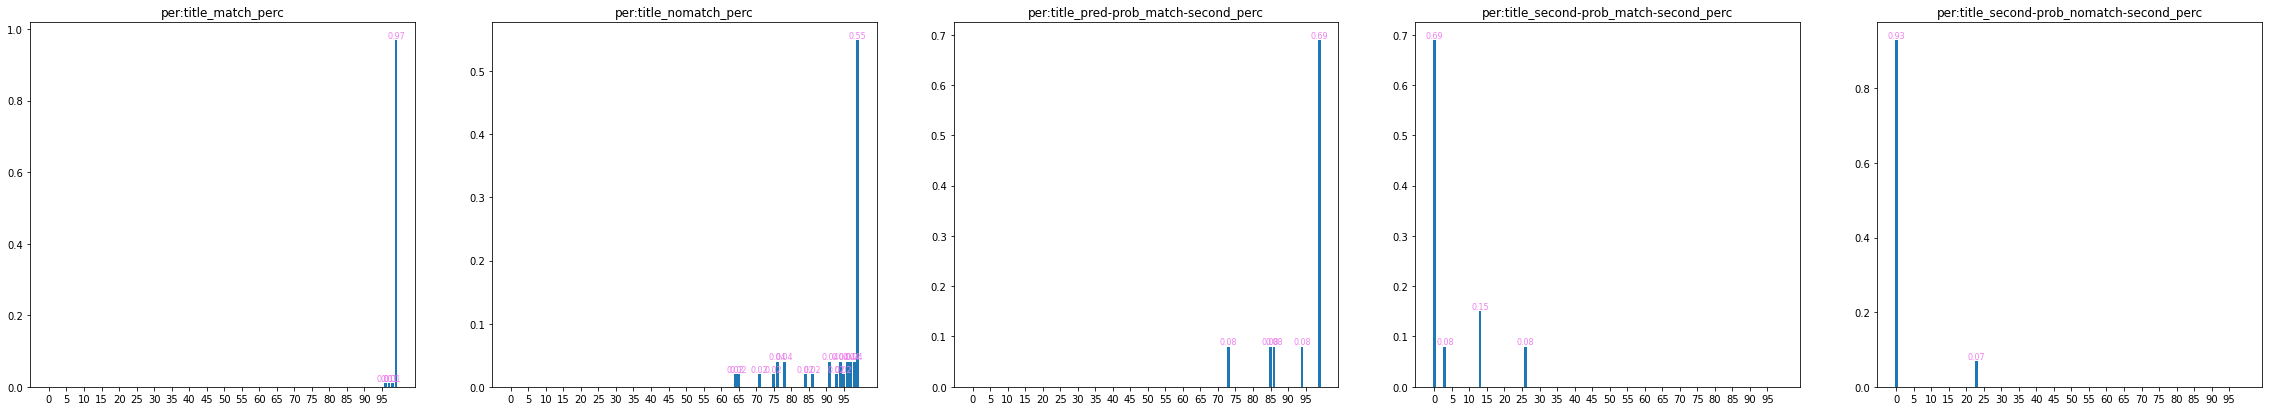

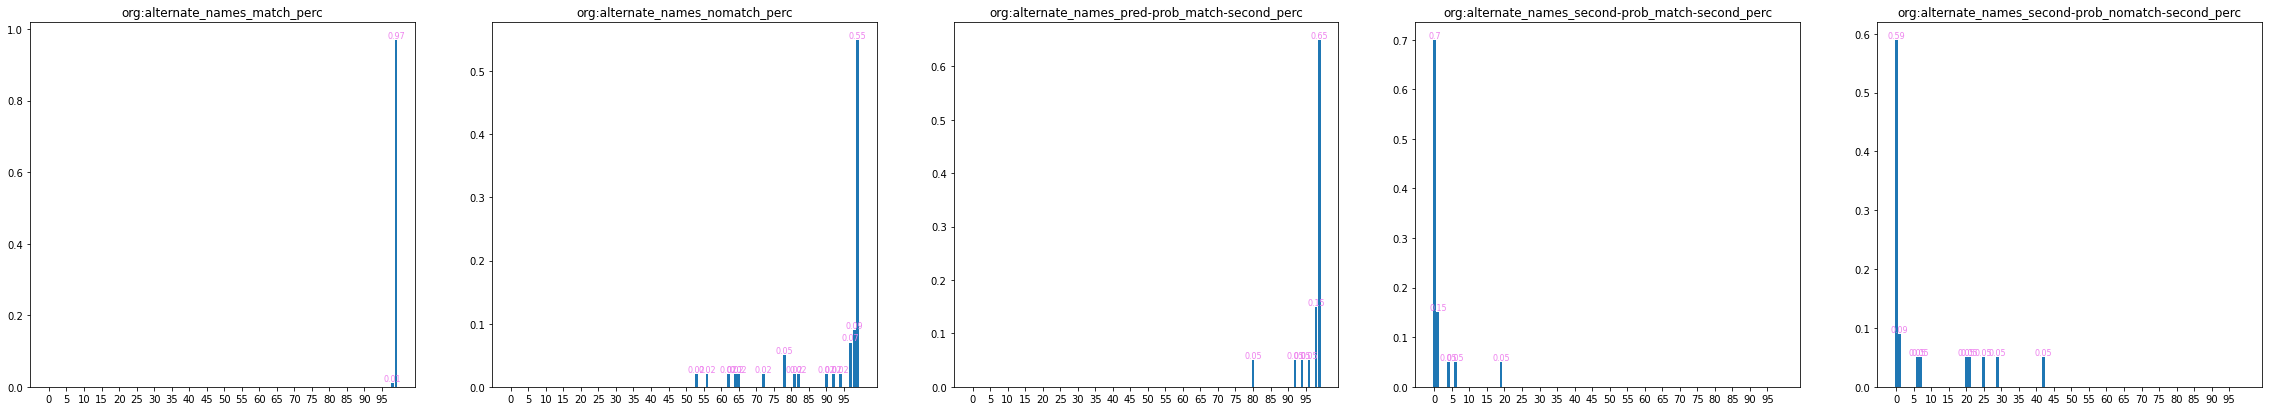

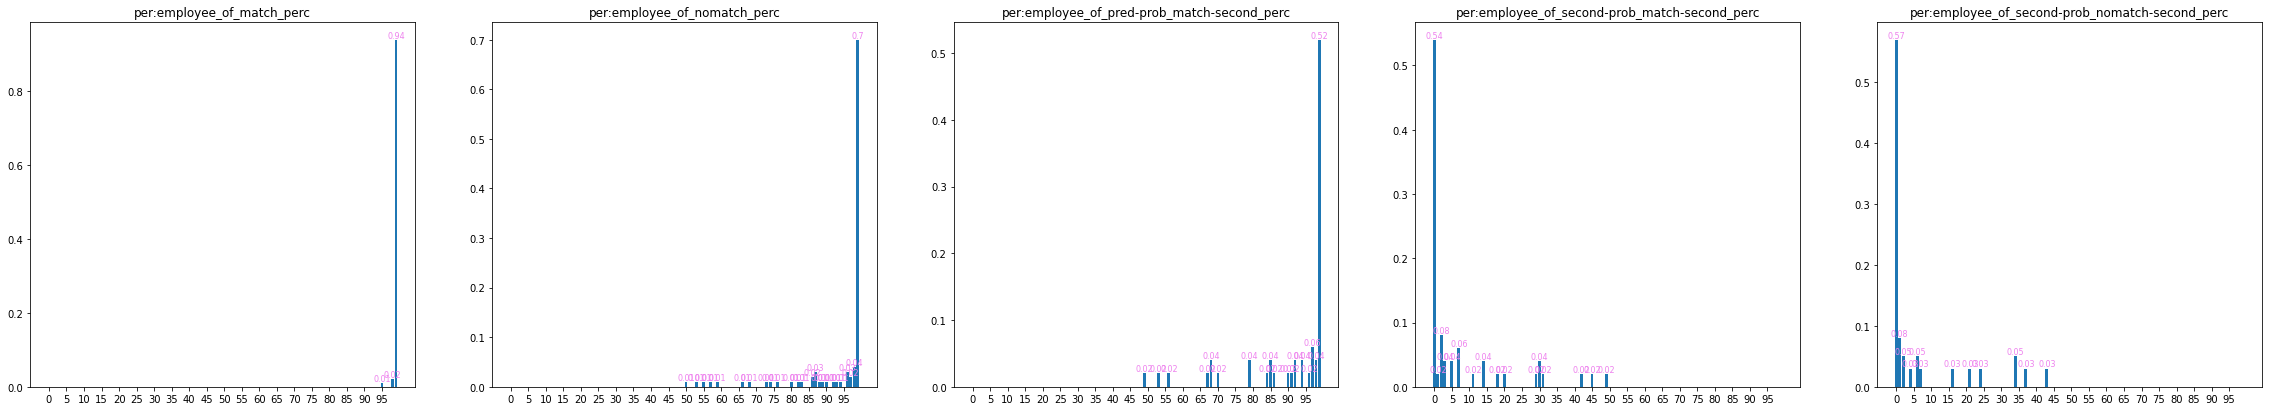

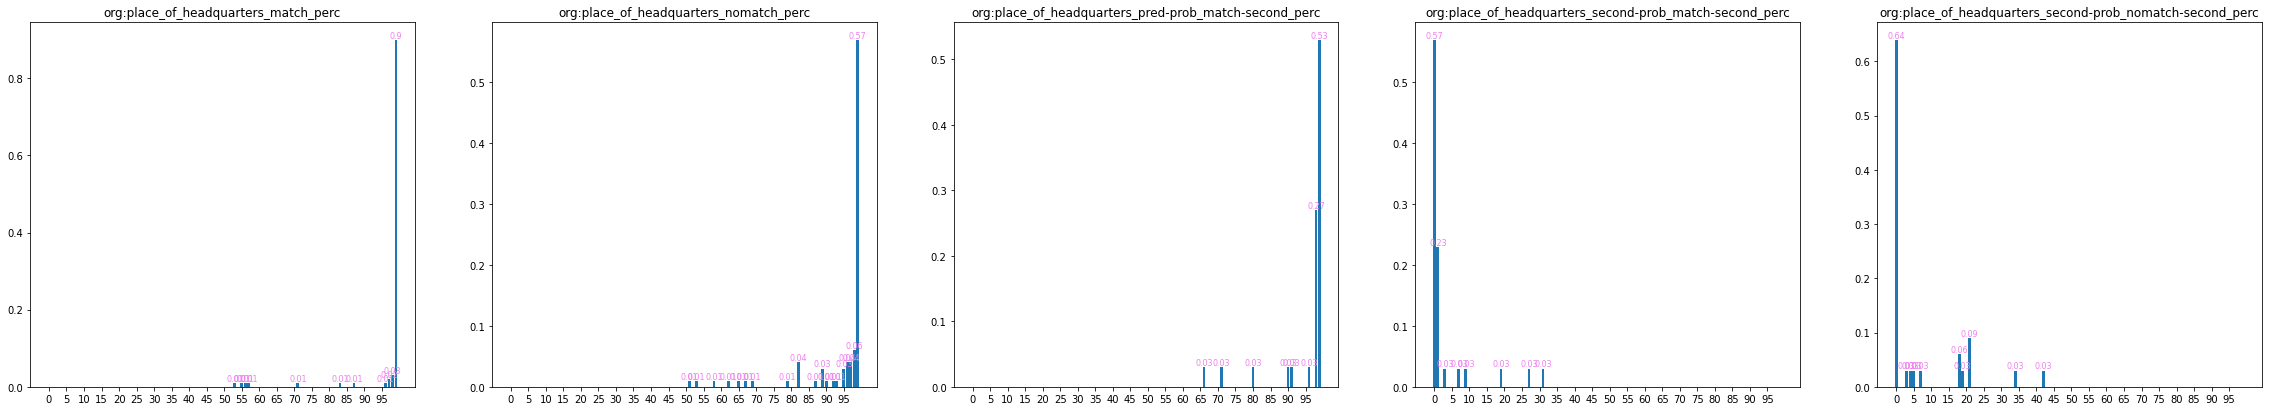

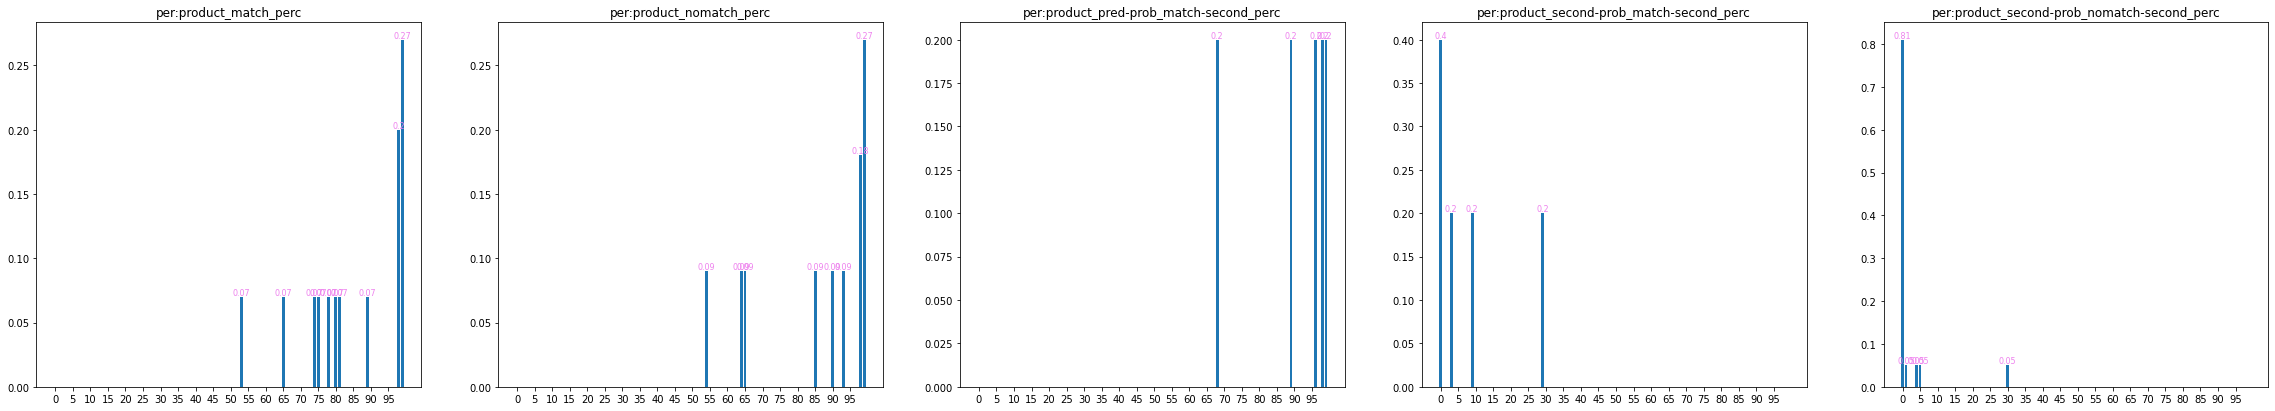

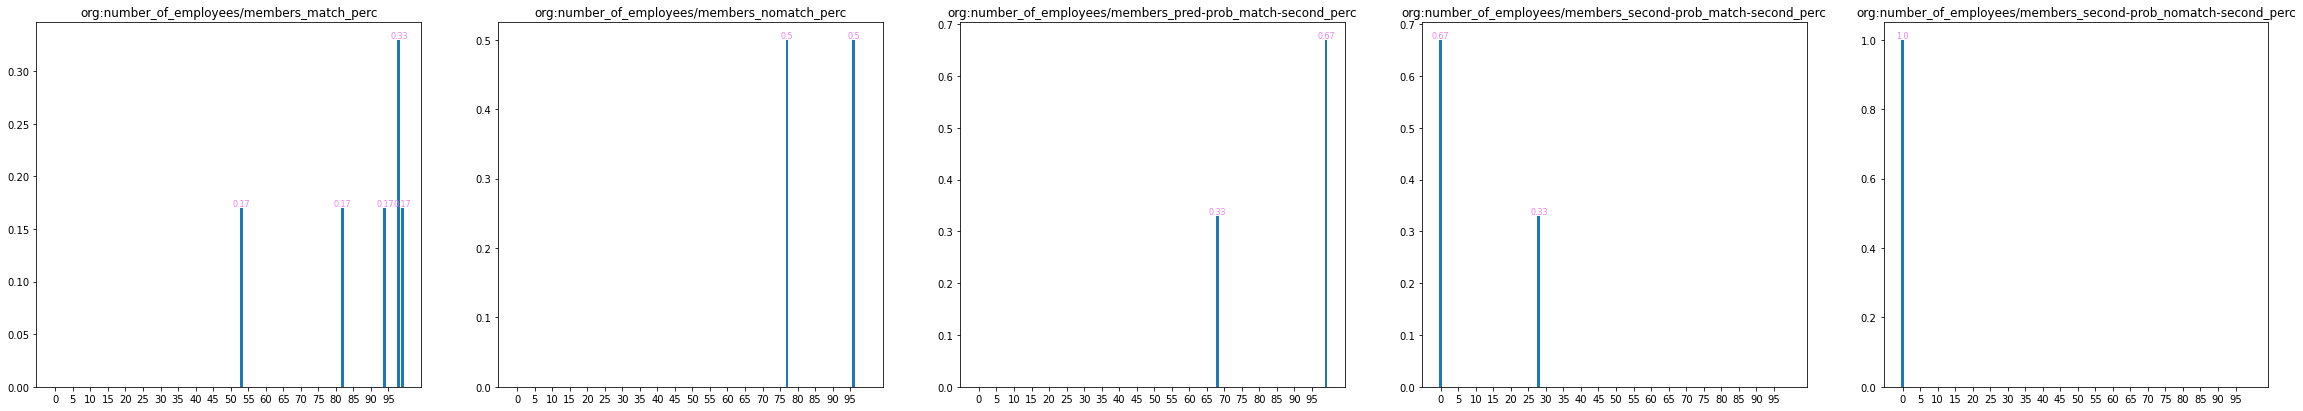

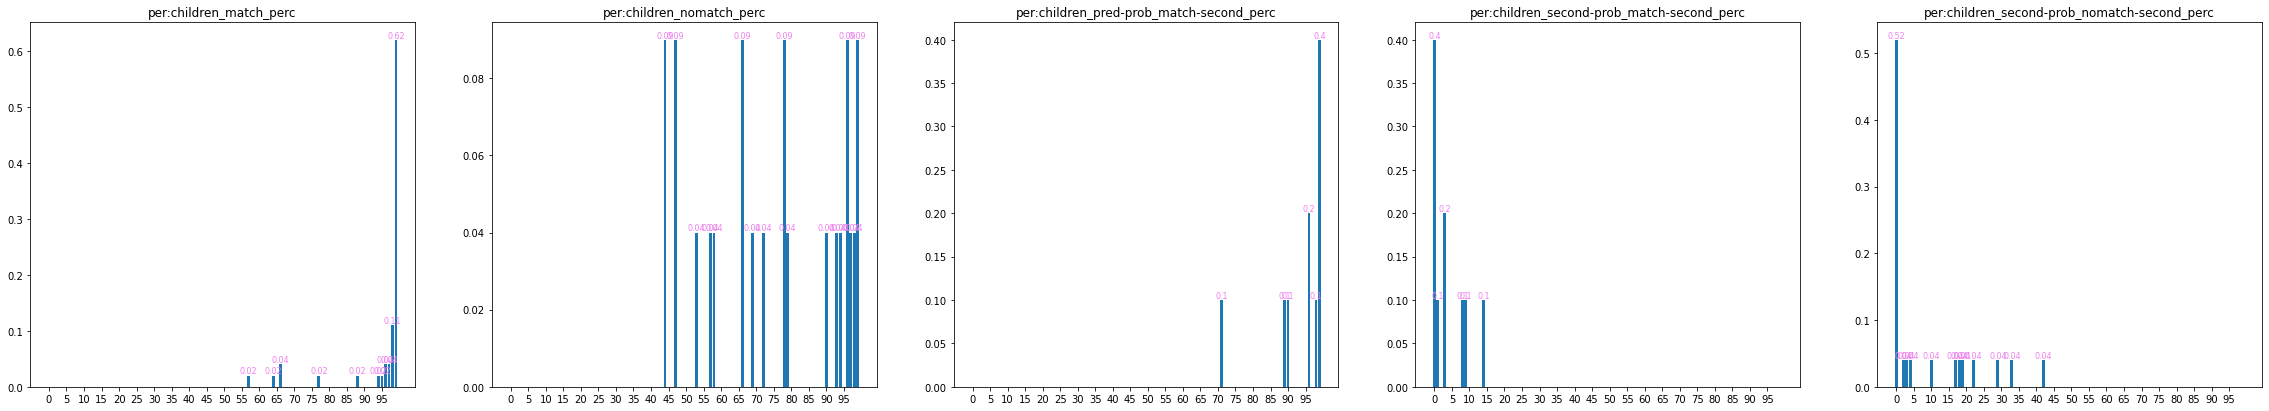

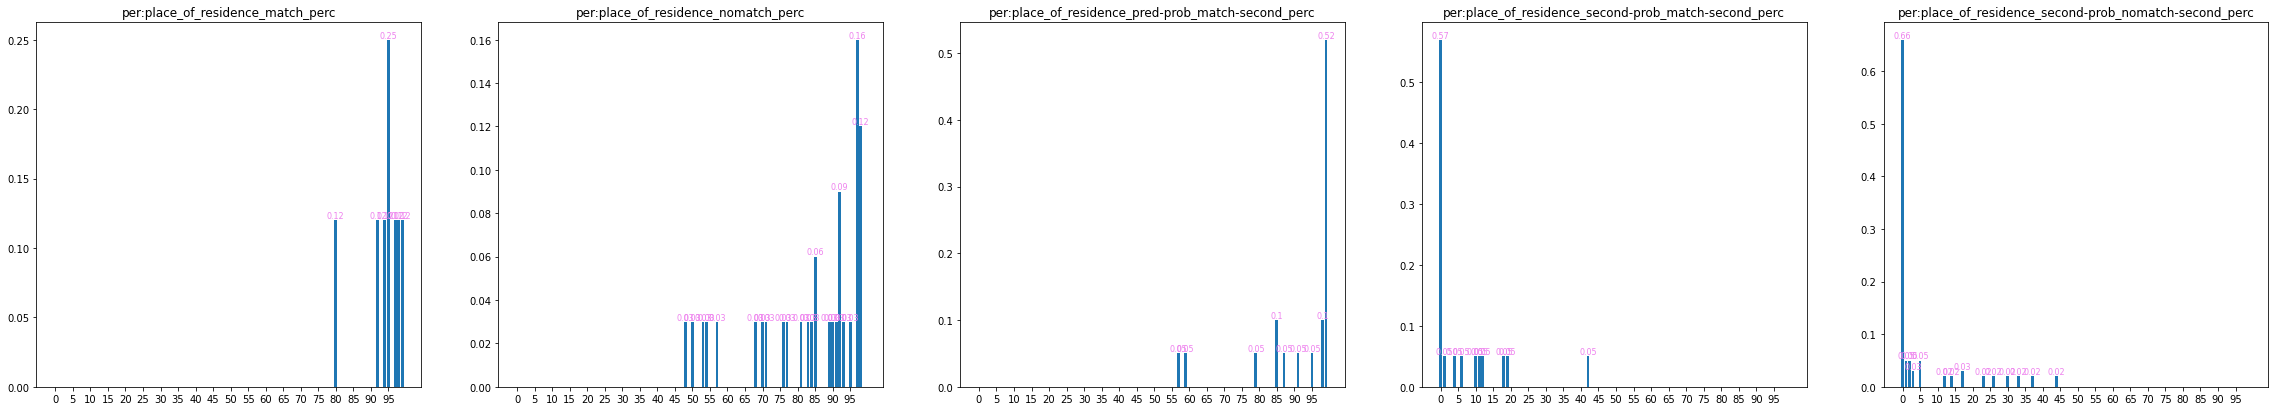

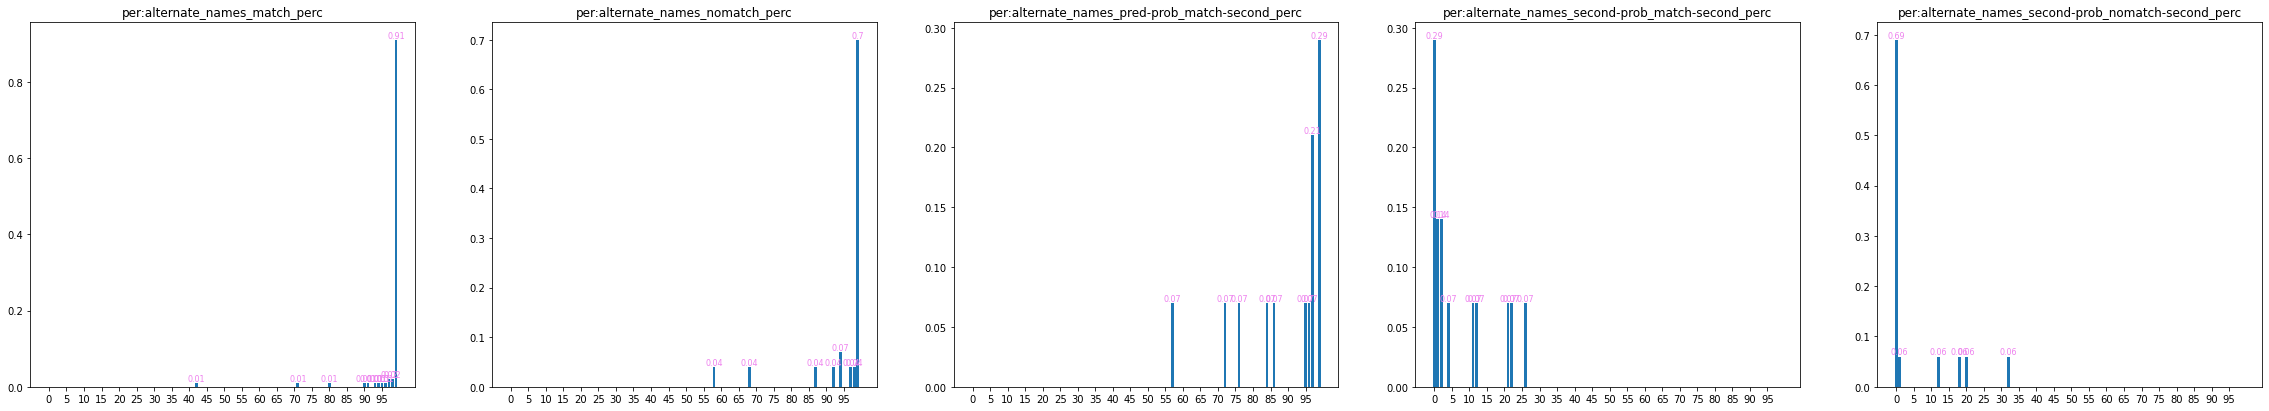

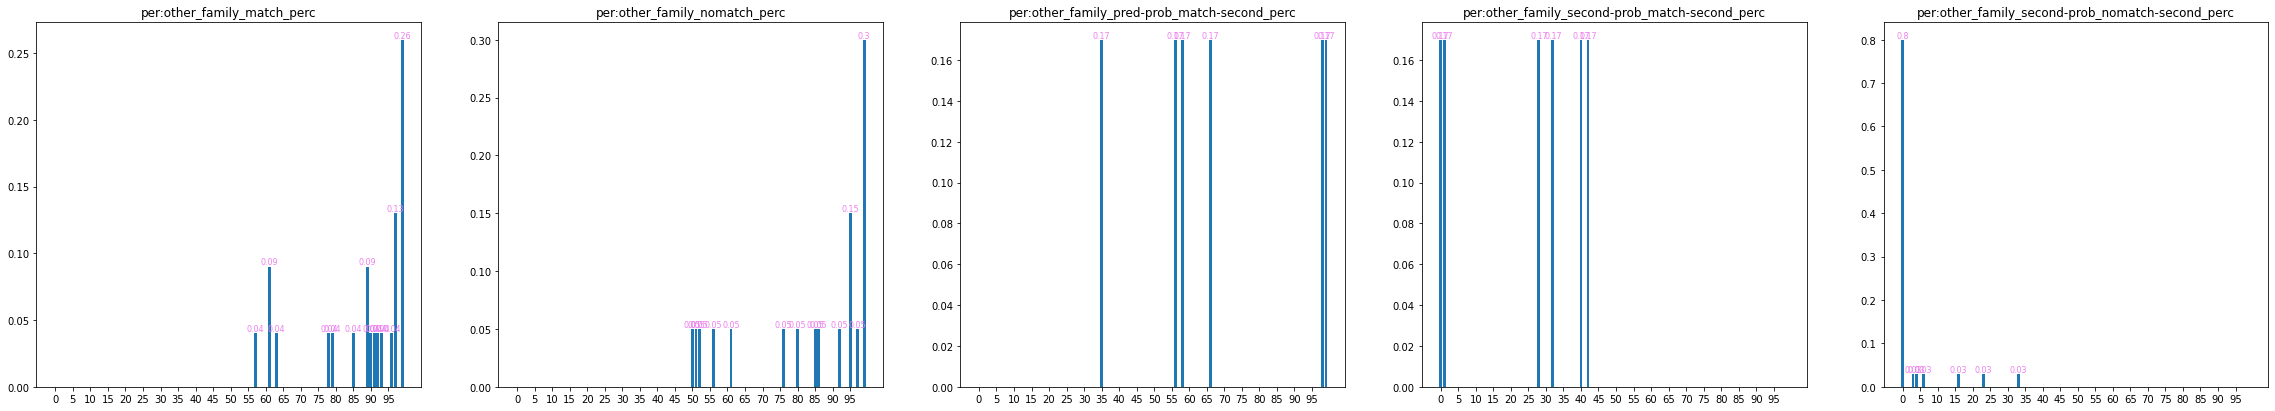

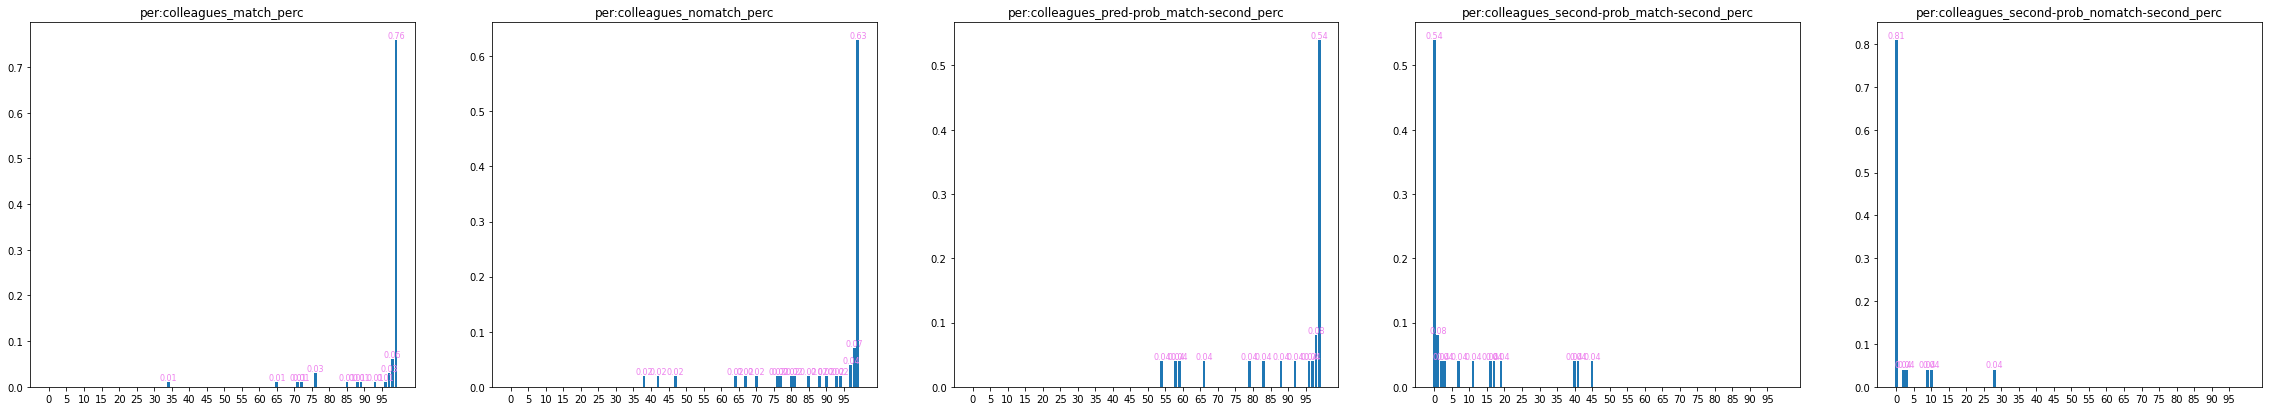

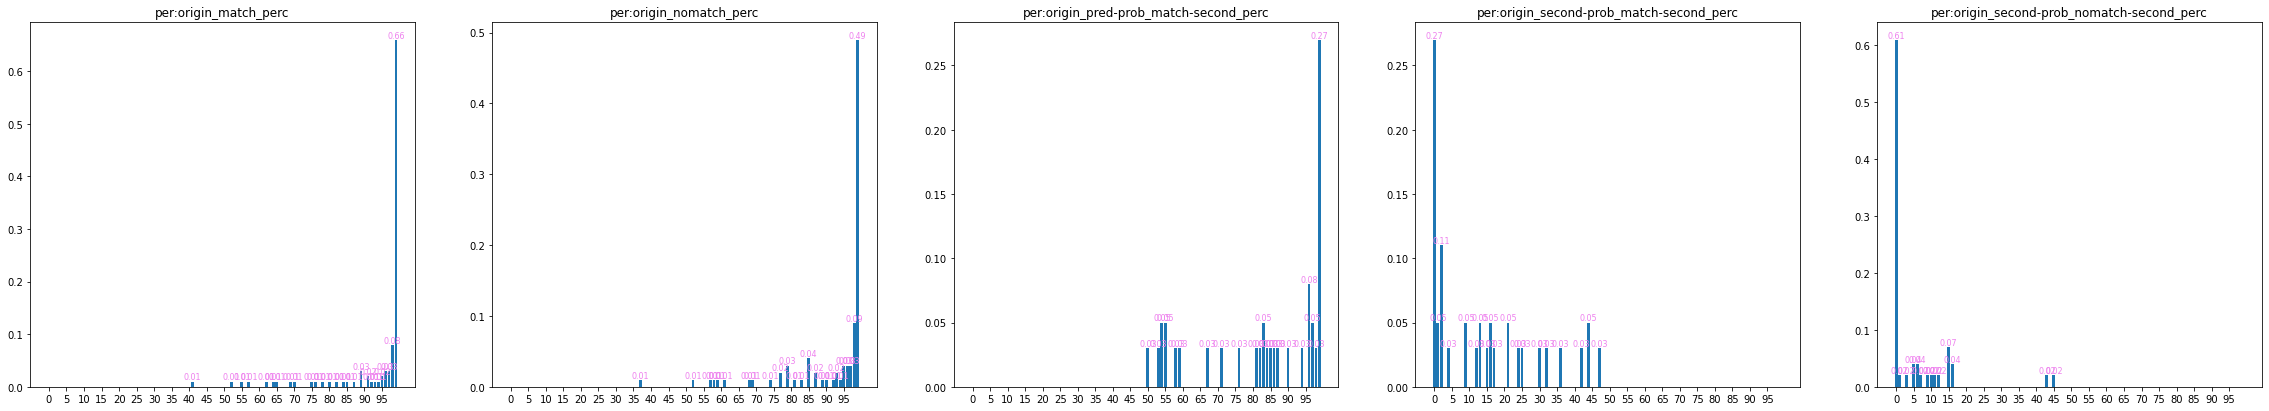

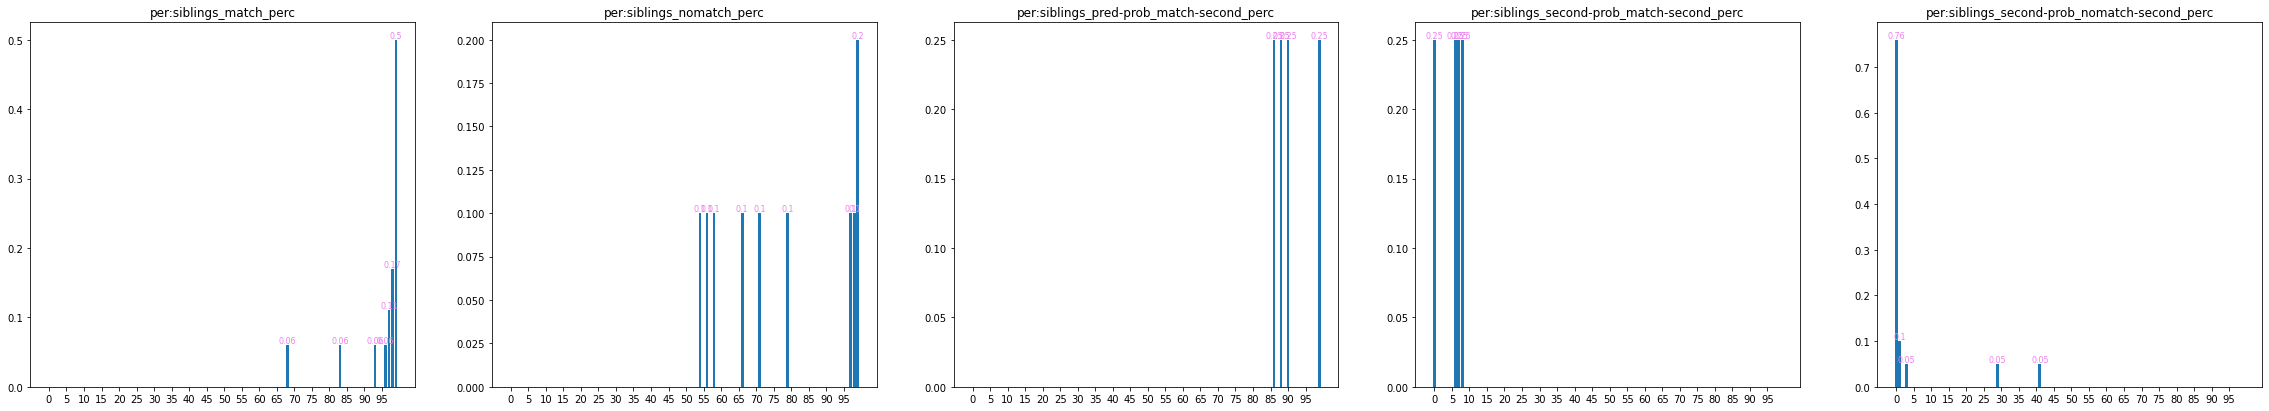

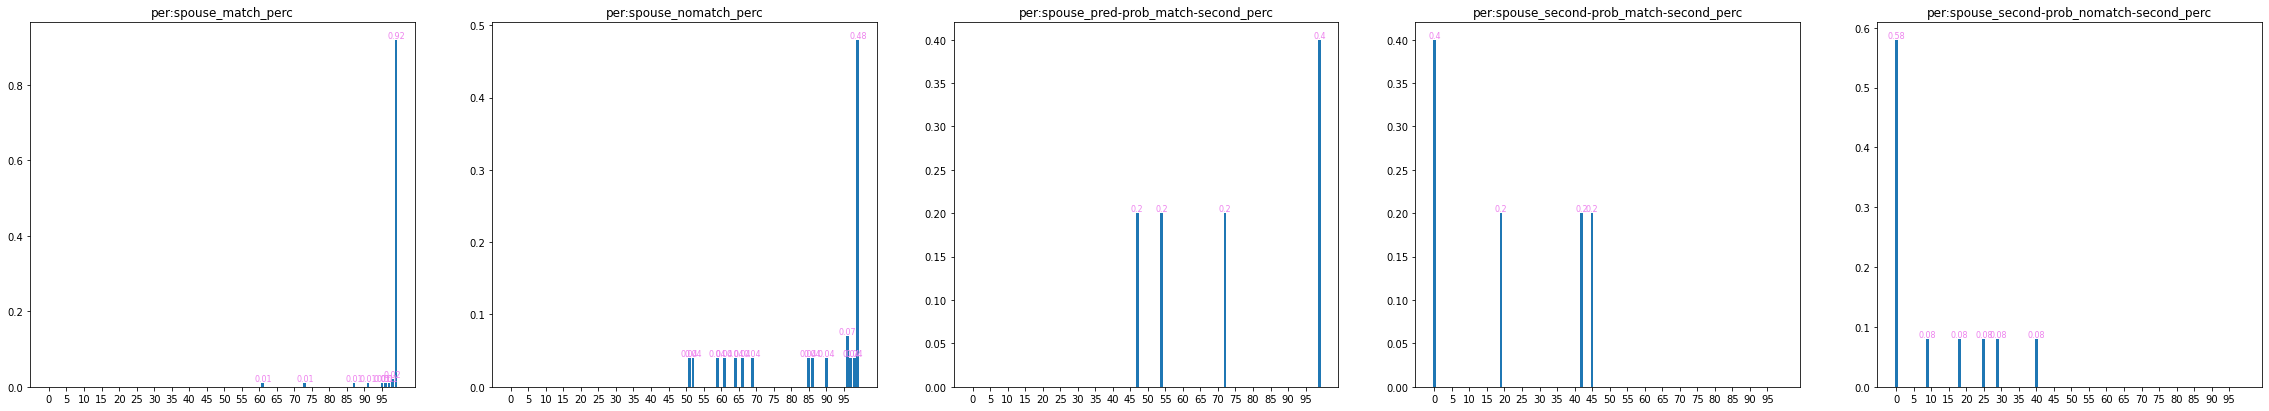

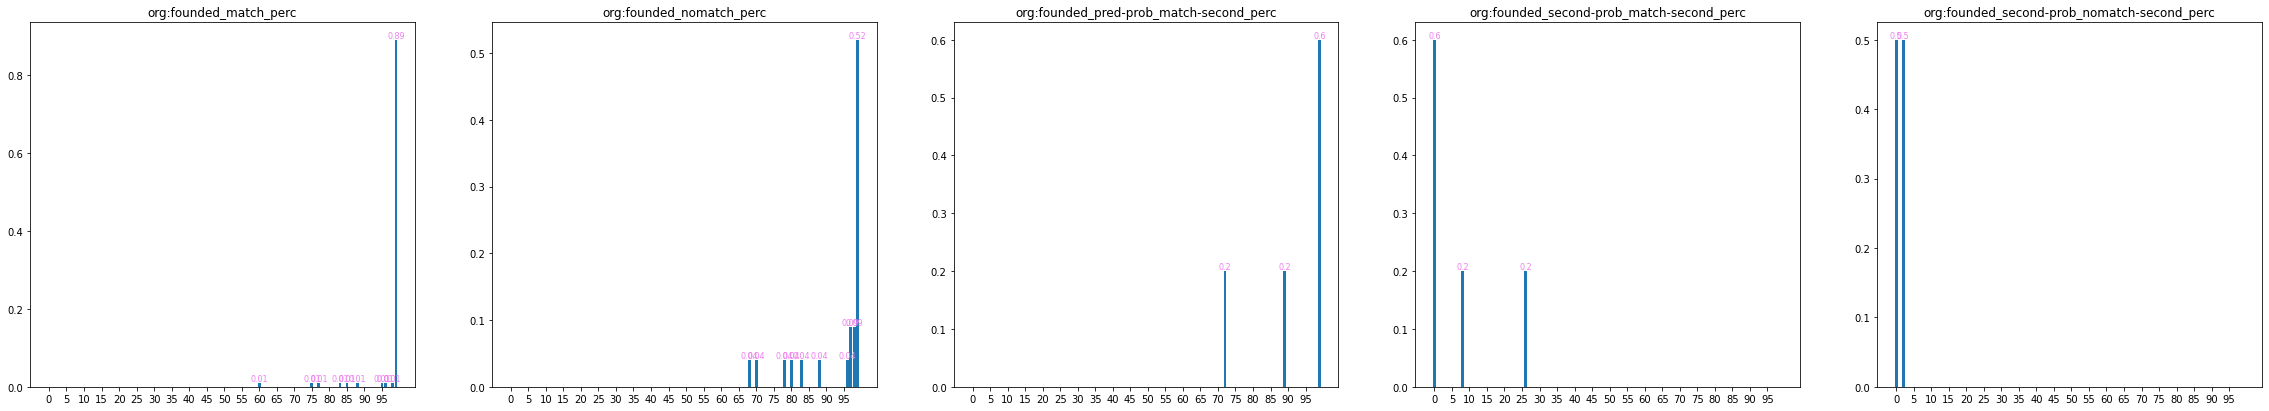

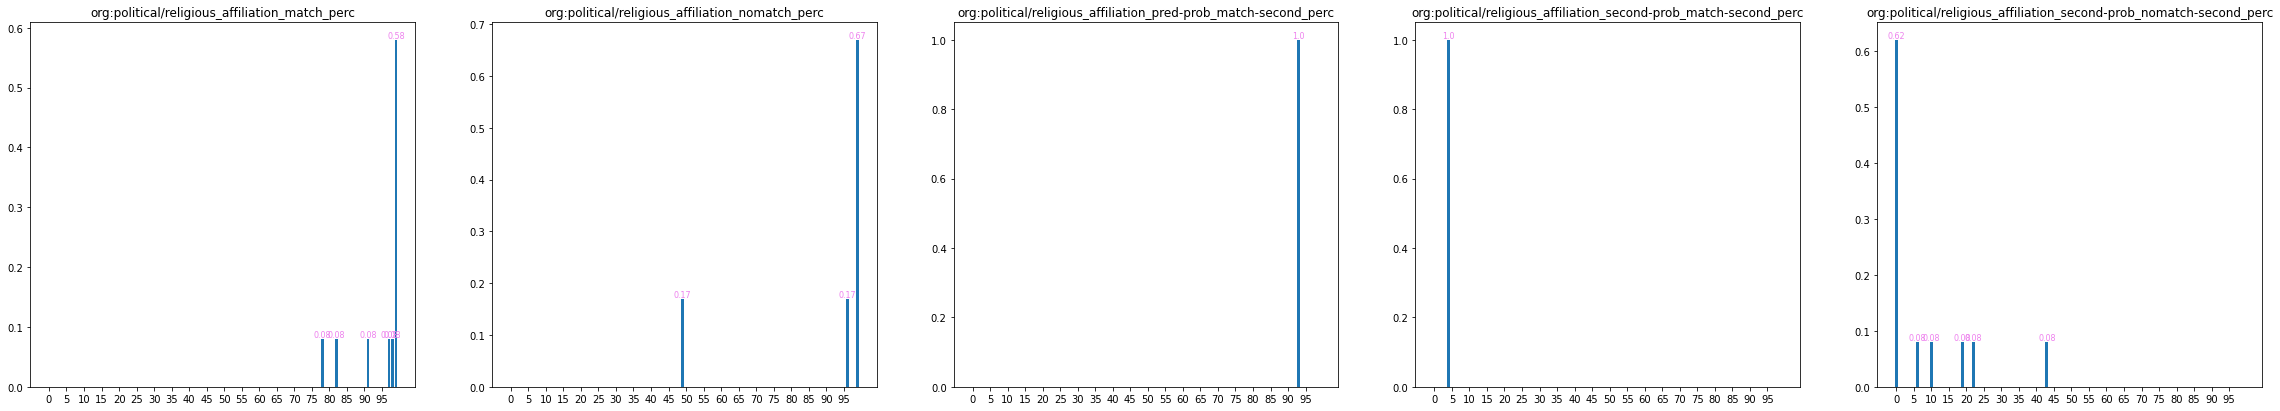

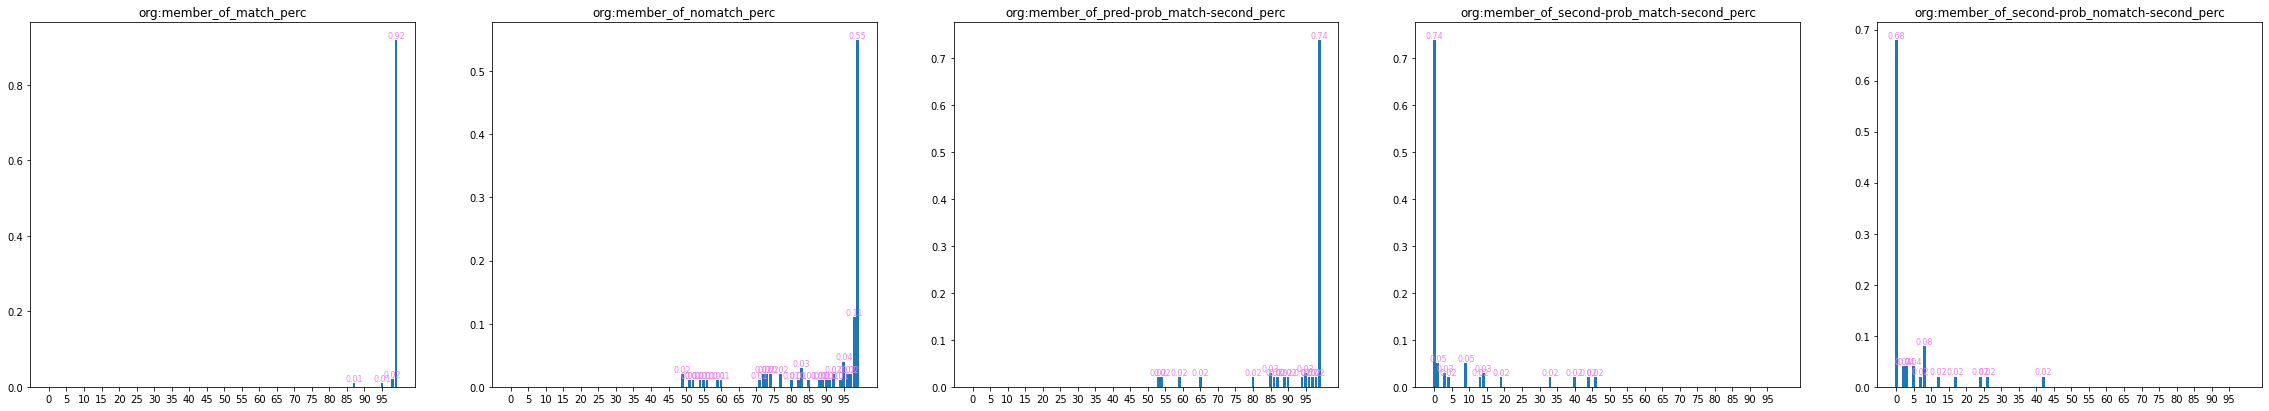

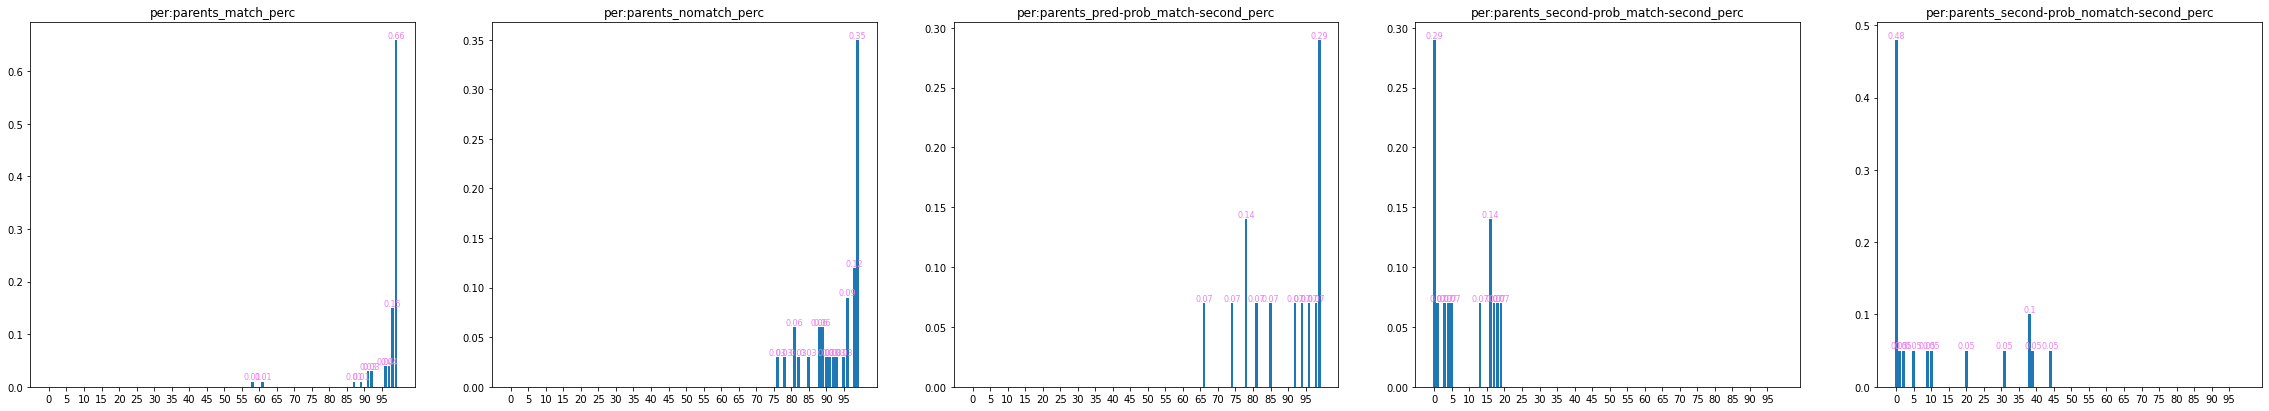

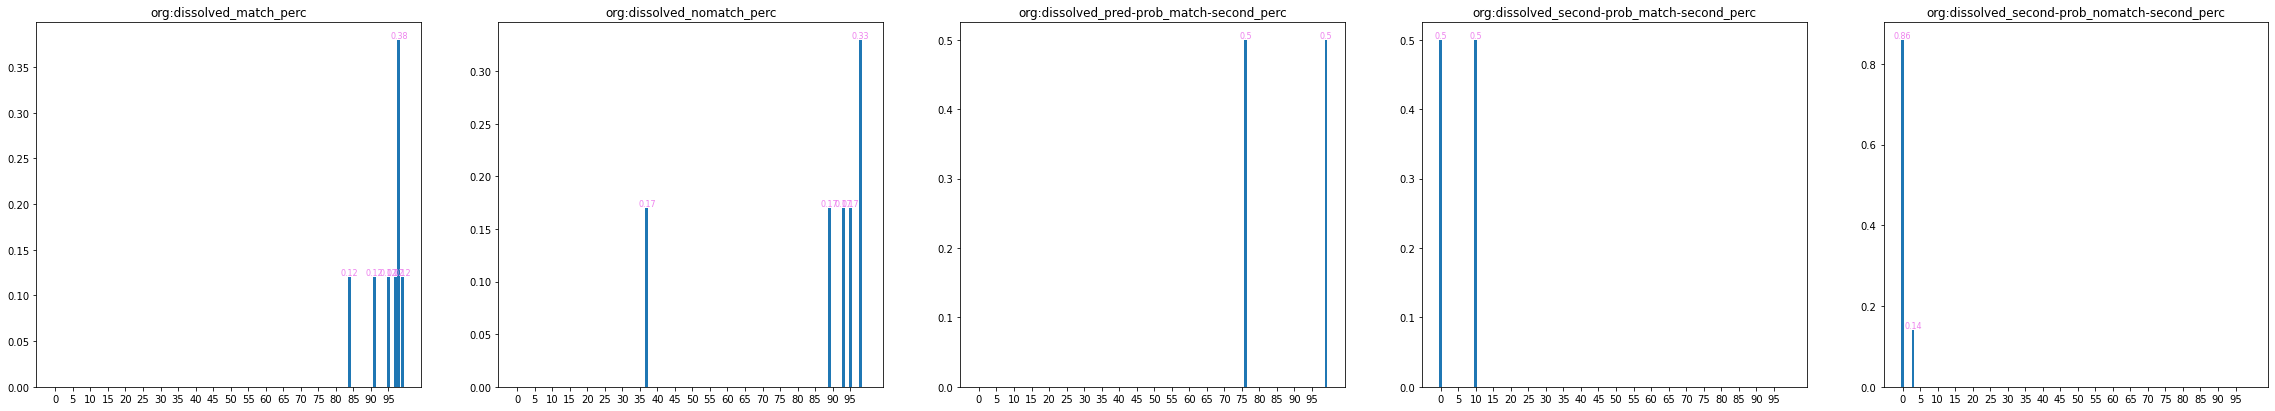

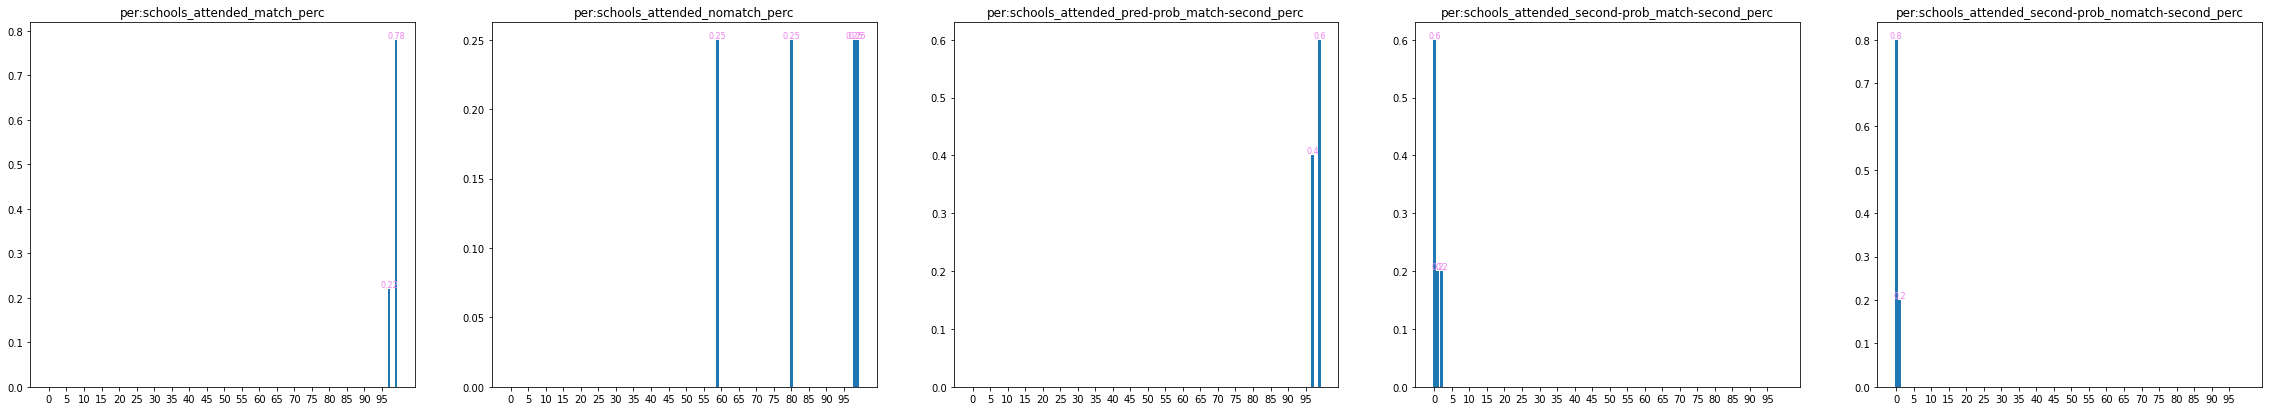

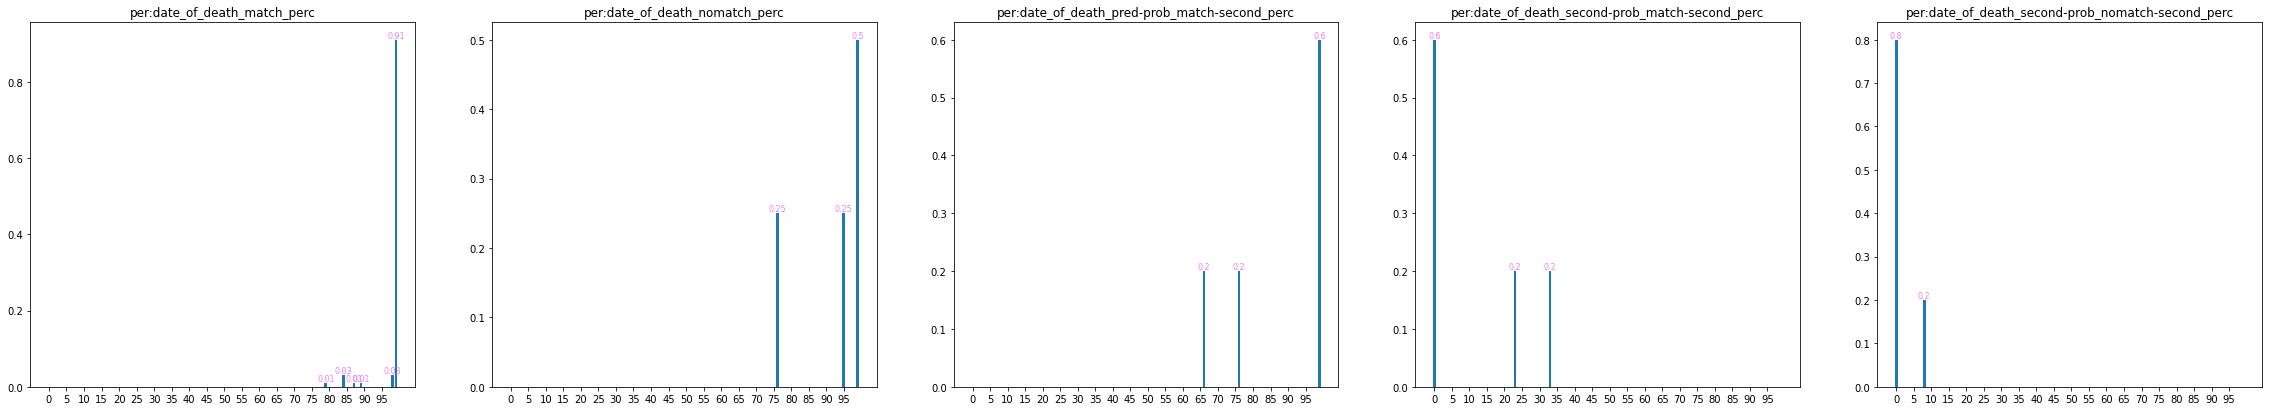

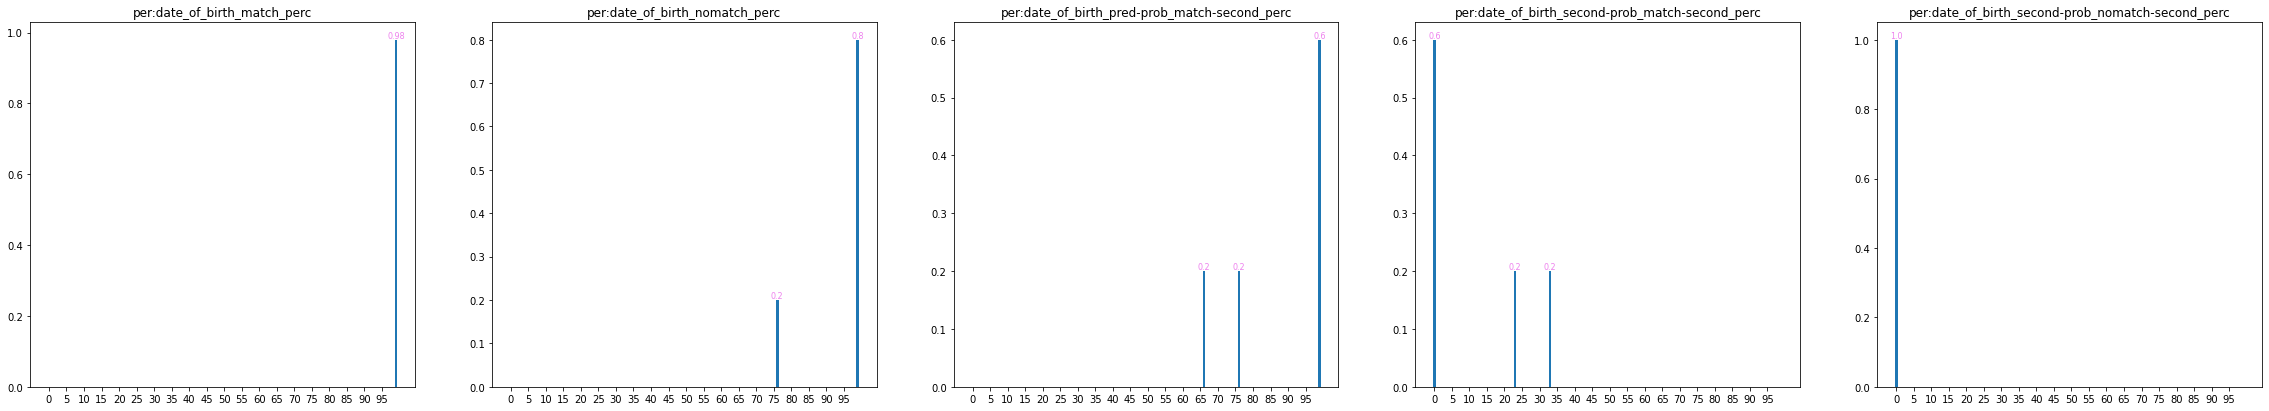

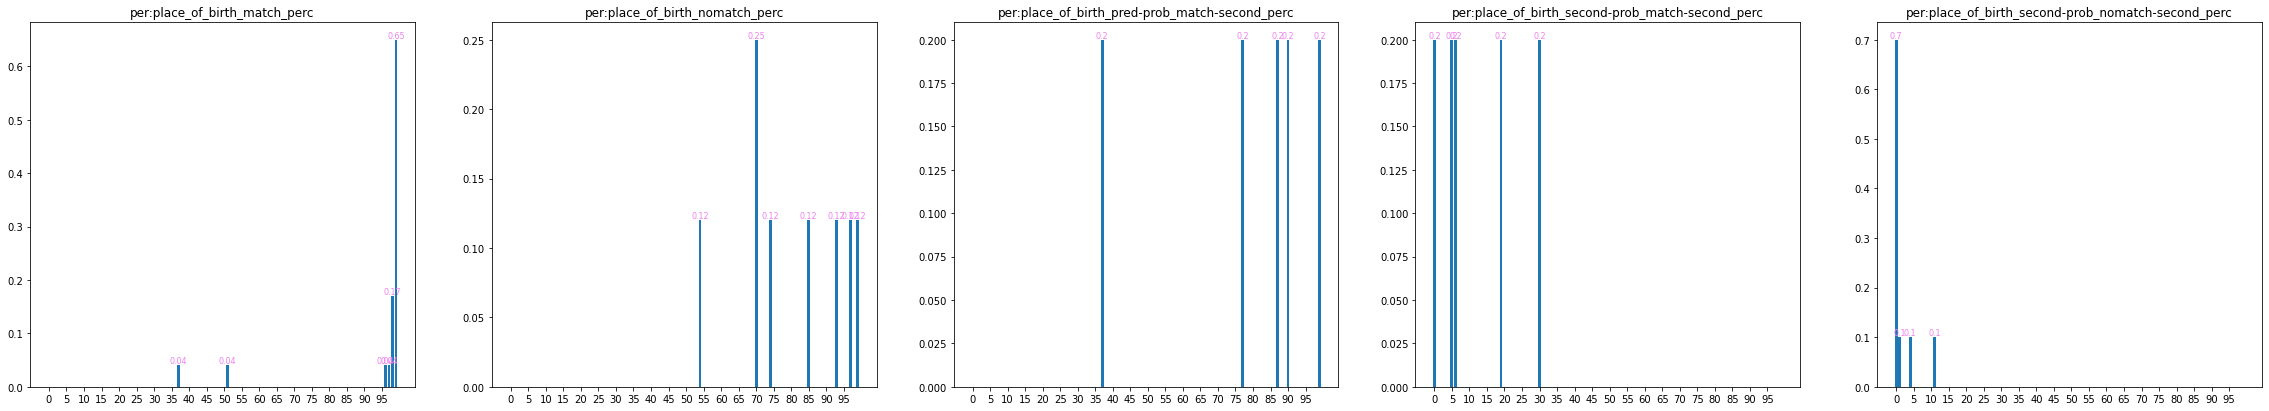

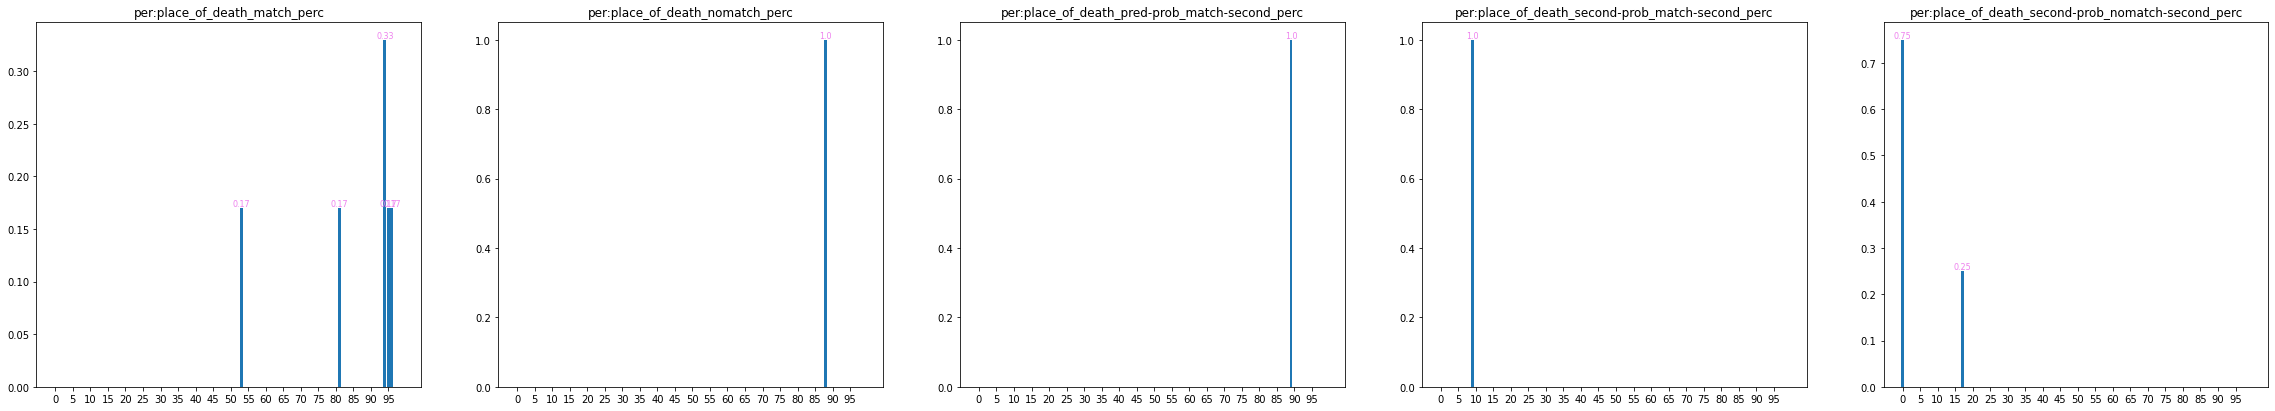

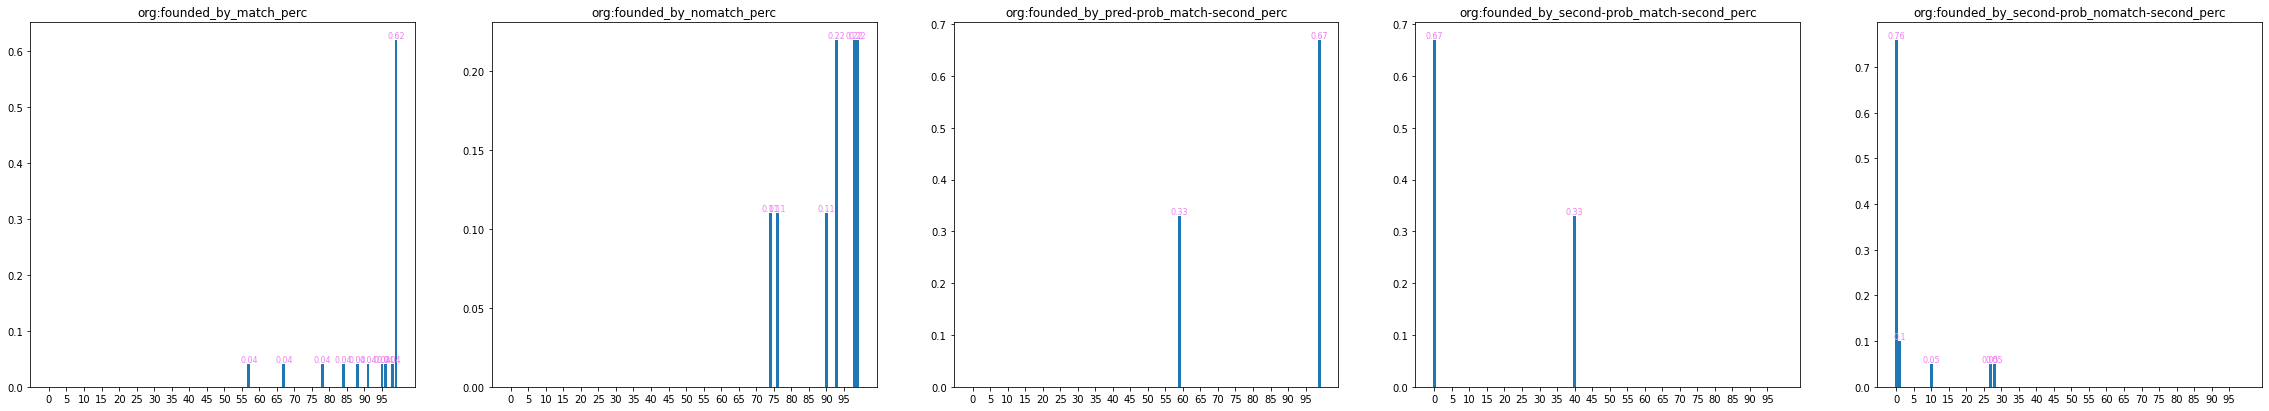

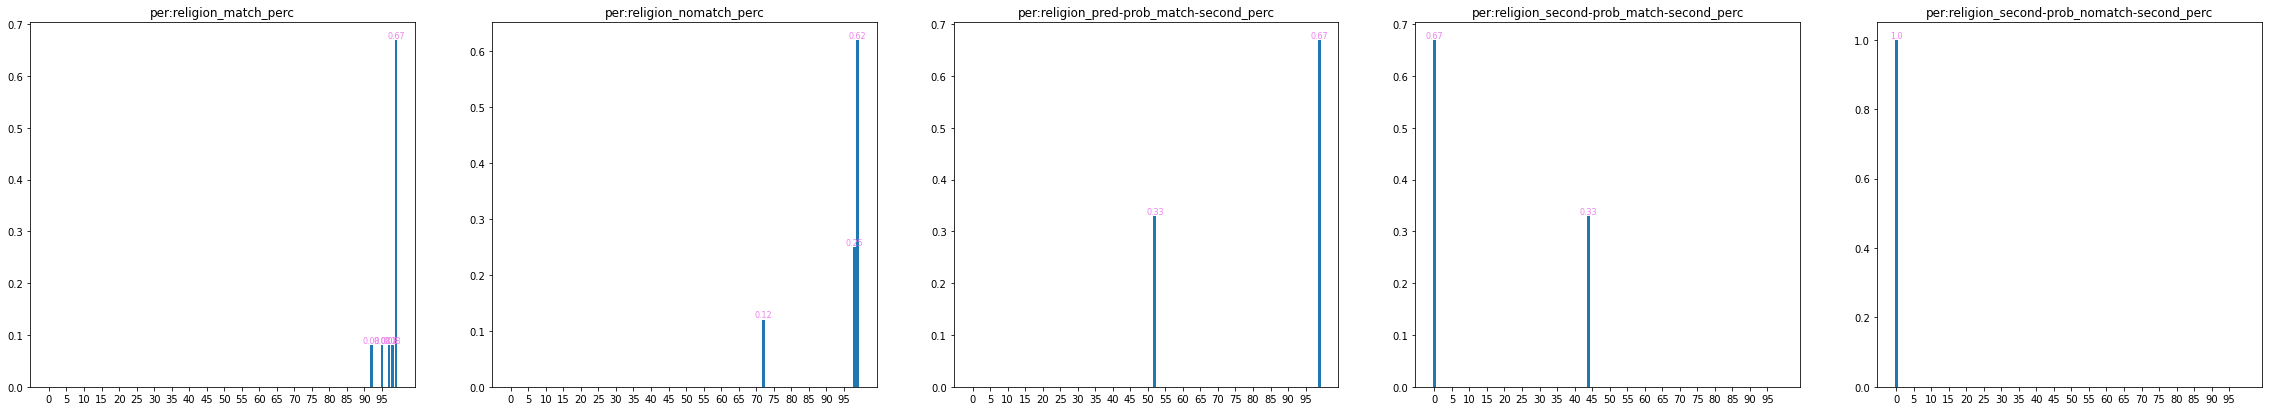

In [41]:
multi_plot('perc')

In [73]:
tp[(tp['gold_label']!='no_relation')&(tp['pred_label']=='no_relation')]

,id,sentence,source,subj_word,subj_start_idx,subj_end_idx,subj_type,obj_word,obj_start_idx,obj_end_idx,...,per:place_of_birth,per:place_of_death,org:founded_by,per:religion,second_label,second_prob,pred_prob,gold_prob,prob_diff,prse_diff
19,9018,이 음반은 또한 믹 테일러가 롤링 스톤스 음반에 처음 등장했고 기타리스트와 창시자인...,wikipedia,롤링 스톤스,71,76,ORG,브라이언 존스,47,53,...,0.0000,0.0000,0.0002,0.0000,org:top_members/employees,0.0005,0.9990,0.0002,0.9989,0.9985
86,12214,팬티 & 스타킹 with 가터벨트는 2010년 10월부터 방영중인 TV애니메이션으로...,wikipedia,니시고리 아쓰시,71,78,PER,팬티 & 스타킹 with 가터벨트,0,17,...,0.0000,0.0000,0.0001,0.0001,per:product,0.0324,0.9653,0.0324,0.9330,0.9330
90,11981,"마리아 테레지아는 자신이 합스부르크 왕가의 영토를 계승하고, 자신의 남편인 로트링겐...",wikipedia,마리아 테레지아,0,7,PER,합스부르크 왕가,14,21,...,0.0000,0.0000,0.0000,0.0000,per:employee_of,0.0016,0.9969,0.0016,0.9953,0.9953
92,22856,"전남대를 비롯해 여수교육지원청, 여수시, 한영대학교, 여수상공회의소, 여수산업단지공...",wikitree,전라남도,63,66,ORG,여수시,18,20,...,0.0000,0.0000,0.0000,0.0000,org:members,0.0000,0.9999,0.0000,0.9999,0.9999
100,22307,아버지 효명세자(孝明世子)가 일찍 요절하여 동궁에 책봉되고 1834년 8세의 나이에...,wikipedia,효명세자,4,7,PER,순원왕후,63,66,...,0.0000,0.0003,0.0001,0.0002,per:other_family,0.3396,0.5172,0.1315,0.3857,0.1776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6397,24264,"앨범의 수록곡은 11곡에서 14곡으로 판마다 차이를 보이는데, 이 중에는 퓨처 컷과...",wikipedia,마크 론슨,136,140,PER,프로듀서,223,226,...,0.0000,0.0000,0.0000,0.0000,per:title,0.0011,0.9981,0.0011,0.9971,0.9971
6404,8264,"카투사는 대한민국 육군에서만 파견하며 대한민국 해군, 대한민국 공군은 카투사를 모집...",wikipedia,카투사,0,2,ORG,대한민국 육군,5,11,...,0.0000,0.0000,0.0000,0.0000,org:member_of,0.1320,0.8655,0.1320,0.7334,0.7334
6407,6134,허 사장은 허창수 GS그룹 명예회장의 장남으로 지난해 GS건설 사장으로 승진했다.,wikitree,GS그룹,10,13,ORG,허창수,6,8,...,0.0000,0.0000,0.0000,0.0000,org:top_members/employees,0.0007,0.9990,0.0007,0.9983,0.9983
6432,18270,"이런 기준에서 “이용빈 후보는 우리 지역의 건강지킴이, 시민운동가, 사회 혁신가로서...",wikitree,더불어민주당,54,59,ORG,문재인,135,137,...,0.0000,0.0000,0.0000,0.0000,org:top_members/employees,0.0003,0.9996,0.0003,0.9992,0.9992
